<a href="https://colab.research.google.com/github/Panos1992/NetLoad_Forecast_residential/blob/main/Net_load_Forecasting_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Data
* Import APIs
* Import the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Mount google drive. to get the pkl file.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Change to your desired directory
#desired_path = '/content/'
desired_path = '/content/drive/MyDrive/Housing_data'
os.chdir(desired_path)

# Verify the current working directory
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  /content/drive/MyDrive/Housing_data


In [ ]:
# MAIN CODE
#if __name__ == "__main__":

# Define the file path
File = 'Data_Households_SmartPV'

# Read data from Excel and store to Pickle file (only need to do this once!)
#read_excel_and_save_pickle(File)

In [ ]:
# Load the dictionary containing DataFrames from the pickle file

with open(File + '.pkl', 'rb') as F:
    household_data = pickle.load(F)
# Concatenate all household consumption data into a single DataFrame
combined_df = pd.concat(household_data.values(), ignore_index=True)


Remove Outliers and Invalid Data

In [ ]:
# Remove NaNs
combined_df['Export'] = combined_df['Export'].fillna(0)
combined_df.drop(combined_df.columns[7:14], axis=1, inplace=True)

##### Remove negative sonsumption ?? ######
combined_df = combined_df[(combined_df['Consumption'] >= 0)]

## Add Net load column? net=cons - prod = import- export
combined_df['NetLoad'] = combined_df['Consumption'] - combined_df['Production']

## Rename columns
#combined_df.rename(columns={'Import': 'Import_W'}, inplace=True)

<ipython-input-7-f8e31910d68d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['NetLoad'] = combined_df['Consumption'] - combined_df['Production']


In [ ]:
# Data should be clean now, without any NaNs
combined_df.info()
combined_df.head(10)
combined_df.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 1187562 entries, 0 to 1194623
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Timestamp    1187562 non-null  datetime64[ns]
 1   NM_meter     1187562 non-null  int64         
 2   Import       1187562 non-null  float64       
 3   Export       1187562 non-null  float64       
 4   PV_meter     1187562 non-null  int64         
 5   Production   1187562 non-null  float64       
 6   Consumption  1187562 non-null  float64       
 7   NetLoad      1187562 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 81.5 MB


Timestamp      NM_meter        Import  \
count                        1187562  1.187562e+06  1.187562e+06   
mean   2016-07-01 22:07:01.935865600  6.149429e+02  5.881864e+02   
min              2016-01-01 00:00:00  4.170000e+02  0.000000e+00   
25%              2016-04-01 13:30:00  5.260000e+02  5.812000e+01   
50%              2016-07-02 01:00:00  5.820000e+02  3.376000e+02   
75%              2016-10-01 04:30:00  7.250000e+02  7.468100e+02   
max              2016-12-31 23:30:00  8.040000e+02  9.672800e+03   
std                              NaN  1.182804e+02  7.669798e+02   

             Export      PV_meter    Production   Consumption       NetLoad  
count  1.187562e+06  1.187562e+06  1.187562e+06  1.187562e+06  1.187562e+06  
mean   3.232560e+02  5.870371e+02  5.556590e+02  8.205894e+02  2.649304e+02  
min    0.000000e+00  4.180000e+02  0.000000e+00  0.000000e+00 -3.463200e+03  
25%    0.000000e+00  5.220000e+02  0.000000e+00  3.110000e+02 -2.880000e+02  
50%    0.000000e+00  5.680000e+02  1.300000e-01  5.206500e+02  3.176600e+02  
75%    4.093875e+02  6.600000e+02  1.111400e+03  1.033267e+03  7.300700e+02  
max    3.463200e+03  7.700000e+02  3.708000e+03  1.102020e+04  9.672800e+03  
std    5.789663e+02  9.536374e+01  7.992396e+02  8.042054e+02  1.129111e+03

In [ ]:
# Convert 'timestamp' column to datetime dtype
combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])

# Extract day, month, and year into separate columns
combined_df['day'] = combined_df['Timestamp'].dt.day
combined_df['day_of_week'] = combined_df['Timestamp'].dt.dayofweek
combined_df['month'] = combined_df['Timestamp'].dt.month
combined_df['year'] = combined_df['Timestamp'].dt.year
combined_df['hour_of_day'] = combined_df['Timestamp'].dt.hour
combined_df['quarter'] = combined_df['Timestamp'].dt.quarter


# Display the DataFrame with new columns
combined_df.info()
combined_df.head(100)

<class 'pandas.core.frame.DataFrame'>
Index: 1187562 entries, 0 to 1194623
Data columns (total 14 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Timestamp    1187562 non-null  datetime64[ns]
 1   NM_meter     1187562 non-null  int64         
 2   Import       1187562 non-null  float64       
 3   Export       1187562 non-null  float64       
 4   PV_meter     1187562 non-null  int64         
 5   Production   1187562 non-null  float64       
 6   Consumption  1187562 non-null  float64       
 7   NetLoad      1187562 non-null  float64       
 8   day          1187562 non-null  int32         
 9   day_of_week  1187562 non-null  int32         
 10  month        1187562 non-null  int32         
 11  year         1187562 non-null  int32         
 12  hour_of_day  1187562 non-null  int32         
 13  quarter      1187562 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(6), int64(2)
memory usage: 108.

Timestamp  NM_meter   Import  Export  PV_meter  Production  \
0  2016-01-01 00:00:00       575  1015.20     0.0       473         0.0   
1  2016-01-01 00:30:00       575   774.03     0.0       473         0.0   
2  2016-01-01 01:00:00       575   718.30     0.0       473         0.0   
3  2016-01-01 01:30:00       575   512.06     0.0       473         0.0   
4  2016-01-01 02:00:00       575   396.24     0.0       473         0.0   
..                 ...       ...      ...     ...       ...         ...   
95 2016-01-02 23:30:00       575   875.51     0.0       473         0.0   
96 2016-01-03 00:00:00       575   871.59     0.0       473         0.0   
97 2016-01-03 00:30:00       575   369.34     0.0       473         0.0   
98 2016-01-03 01:00:00       575   394.34     0.0       473         0.0   
99 2016-01-03 01:30:00       575   300.76     0.0       473         0.0   

    Consumption  NetLoad  day  day_of_week  month  year  hour_of_day  quarter  
0       1015.20  1015.20    1            4      1  2016            0        1  
1        774.03   774.03    1            4      1  2016            0        1  
2        718.30   718.30    1            4      1  2016            1        1  
3        512.06   512.06    1            4      1  2016            1        1  
4        396.24   396.24    1            4      1  2016            2        1  
..          ...      ...  ...          ...    ...   ...          ...      ...  
95       875.51   875.51    2            5      1  2016           23        1  
96       871.59   871.59    3            6      1  2016            0        1  
97       369.34   369.34    3            6      1  2016            0        1  
98       394.34   394.34    3            6      1  2016            1        1  
99       300.76   300.76    3            6      1  2016            1        1  

[100 rows x 14 columns]

In [ ]:
# Check if there are missing values after cleaning
missing_values = combined_df[combined_df.isnull().any(axis=1)]
print(missing_values)

Empty DataFrame
Columns: [Timestamp, NM_meter, Import, Export, PV_meter, Production, Consumption, NetLoad, day, day_of_week, month, year, hour_of_day, quarter]
Index: []


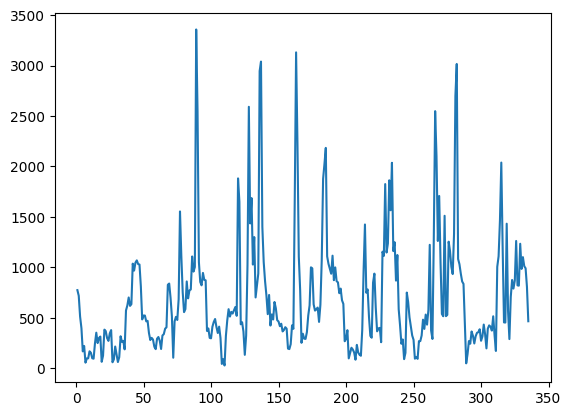

In [ ]:
# Plot 1st week

plt.plot(combined_df['Consumption'].iloc[1:48*7])

In [ ]:
# Export the DataFrame to a CSV file
#combined_df.to_csv('Data_Households_SmartPV.csv', index=False)  # Set index=False to not save row indices in the file



# Data Analysis for Individual Houses

* Average all houses in 1 datasheet
* Total Power for each house
*	Group Monthly: Make monthly consumptions for each house
*	Group yearly: Yearly consumption each house




In [ ]:
# Estimate Averages of each house
# group by PV_meter
# estimate means of each house
mean_df = combined_df.groupby(['PV_meter','NM_meter']).mean().reset_index()
#mean_df = combined_df.groupby('PV_meter').agg({'Import':'mean', 'Export':'mean', 'Consumption':'mean', 'Production':'mean'}).reset_index()

'''# Add KWh columns??
mean_df['Import_KWh'] = mean_df['Import'] * (24/1000)
mean_df['Export_KWh'] = mean_df['Export'] * (24/1000)
mean_df['Consumption_KWh'] = mean_df['Consumption'] * (24/1000)
mean_df['Production_KWh'] = mean_df['Production'] * (24/1000)
mean_df['NetLoad_KWh'] = mean_df['Import_KWh']-mean_df['Export_KWh'] '''

mean_df.info()
mean_df.head(30)
#mean_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   PV_meter     68 non-null     int64         
 1   NM_meter     68 non-null     int64         
 2   Timestamp    68 non-null     datetime64[ns]
 3   Import       68 non-null     float64       
 4   Export       68 non-null     float64       
 5   Production   68 non-null     float64       
 6   Consumption  68 non-null     float64       
 7   NetLoad      68 non-null     float64       
 8   day          68 non-null     float64       
 9   day_of_week  68 non-null     float64       
 10  month        68 non-null     float64       
 11  year         68 non-null     float64       
 12  hour_of_day  68 non-null     float64       
 13  quarter      68 non-null     float64       
dtypes: datetime64[ns](1), float64(11), int64(2)
memory usage: 7.6 KB


PV_meter  NM_meter                     Timestamp       Import      Export  \
0        418       417 2016-07-02 00:15:32.430124544   772.817469  257.284148   
1        420       419 2016-07-02 00:20:34.733606400   690.450924  255.067524   
2        428       792 2016-07-02 00:20:34.733606400   508.645933  397.322385   
3        433       432 2016-07-02 00:20:34.733606400   502.920390  341.960947   
4        438       435 2016-07-02 00:20:34.733606400  1260.707665  233.611010   
5        466       619 2016-07-01 07:55:57.400468480   472.007523  307.623835   
6        473       575 2016-07-02 00:20:34.733606400   556.209209  273.264644   
7        474       714 2016-07-03 02:21:41.132213248   794.700657  272.479766   
8        488       487 2016-06-30 12:53:04.074052608   866.115249  210.405984   
9        490       489 2016-07-02 00:20:34.733606400   631.977306  369.282589   
10       495       494 2016-07-04 18:39:11.520806144   424.340207  362.211516   
11       504       675 2016-06-30 08:52:57.530935296   556.165111  342.098325   
12       507       683 2016-07-02 00:20:34.733606400   858.947404  281.152277   
13       508       798 2016-07-02 07:03:46.365370368   540.313009  206.727388   
14       513       440 2016-06-28 23:19:47.454260224   428.414206  356.359010   
15       518       760 2016-06-29 18:40:28.465761280   736.031860  355.034515   
16       519       520 2016-07-02 00:20:34.733606400   521.297704  429.158033   
17       522       556 2016-07-02 12:17:24.471387136   519.324522  388.783972   
18       529       509 2016-06-30 09:41:15.363321856   602.169117  323.531037   
19       531       512 2016-06-29 12:20:36.958915328   591.087155  369.463819   
20       535       534 2016-07-02 00:20:34.733606400   534.998410  347.270074   
21       539       536 2016-07-02 00:20:34.733606400   559.423060  283.924117   
22       541       540 2016-07-02 00:20:34.733606400   364.639255  325.733879   
23       542       772 2016-07-02 00:20:34.733606400   421.767168  375.022905   
24       544       767 2016-07-02 00:15:32.430124544   684.928696  331.481573   
25       546       766 2016-07-02 01:03:17.472246016   662.336601  290.481708   
26       547       545 2016-07-02 00:20:34.733606400   584.850562  271.881783   
27       549       764 2016-07-02 00:23:00.406443776   581.744179  355.175181   
28       552       551 2016-07-02 00:20:34.733606400   525.619566  318.724148   
29       557       555 2016-07-02 07:40:59.052289280   383.697684  420.534016   

    Production  Consumption      NetLoad        day  day_of_week     month  \
0   486.959154  1002.492475   515.533321  15.758012     3.008197  6.514317   
1   578.196938  1013.580338   435.383400  15.757172     3.008197  6.514458   
2   547.666943   658.990491   111.323548  15.757172     3.008197  6.514458   
3   590.713889   751.673333   160.959443  15.757172     3.008197  6.514458   
4   547.217905  1574.314559  1027.096654  15.757172     3.008197  6.514458   
5   558.058557   722.442245   164.383688  15.760187     2.995023  6.492037   
6   506.065479   789.010045   282.944566  15.757172     3.008197  6.514458   
7   549.042151  1071.263042   522.220891  15.773679     3.028488  6.549245   
8   476.545952  1132.255218   655.709265  15.780601     3.008337  6.465302   
9   528.842025   791.536742   262.694717  15.757172     3.008197  6.514458   
10  597.595867   659.724557    62.128690  15.765628     3.021957  6.604342   
11  556.745395   770.812181   214.066786  15.762014     3.010993  6.460432   
12  550.916681  1128.711808   577.795128  15.757172     3.008197  6.514458   
13  601.322056   934.907677   333.585621  15.745420     3.008033  6.524013   
14  546.504381   618.559577    72.055196  15.754371     3.009758  6.414881   
15  579.147713   960.145057   380.997344  15.780121     3.014967  6.440451   
16  614.131653   706.271324    92.139671  15.757172     3.008197  6.514458   
17  708.274929   838.815478   130.540549  15.773824     3.011882  6.530068   
18  562.03

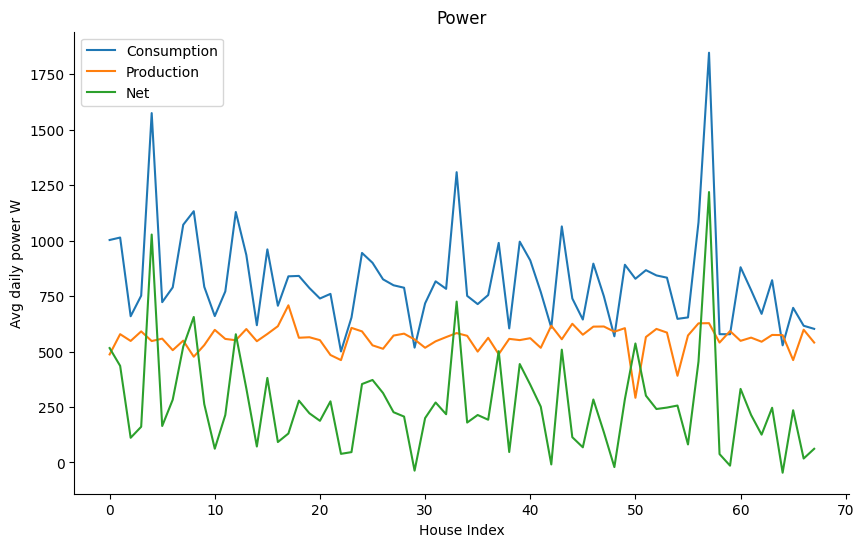

In [ ]:
# @title Import
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
mean_df['Consumption'].plot(kind='line', title='Power')
mean_df['Production'].plot(kind='line')
mean_df['NetLoad'].plot(kind='line')

plt.gca().spines[['top', 'right']].set_visible(False)

plt.legend([ 'Consumption', 'Production', 'Net'])  # Add a legend to distinguish between the two lines
plt.xlabel('House Index')  # Add x-axis label if needed
plt.ylabel('Avg daily power W')  # Add y-axis label if needed
plt.show()

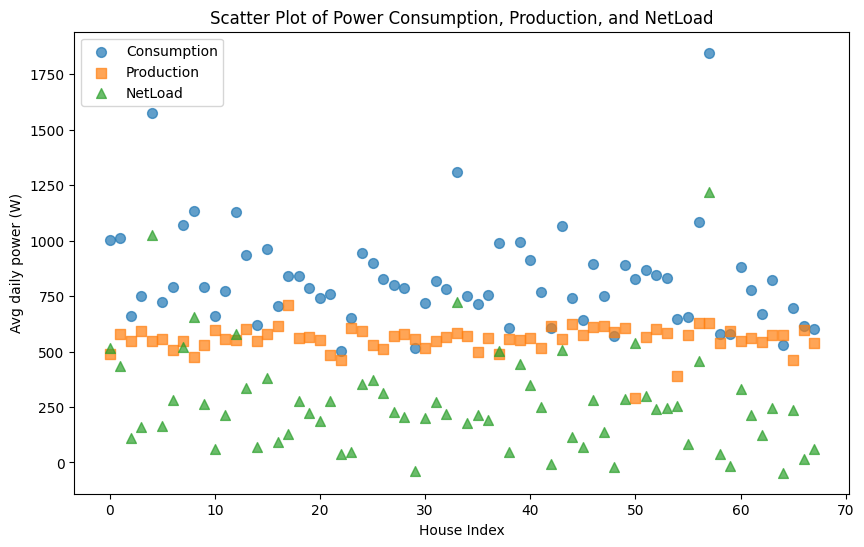

In [ ]:
# Import necessary libraries
from matplotlib import pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Scatter plot for Consumption
plt.scatter(mean_df.index, mean_df['Consumption'], label='Consumption', marker='o', alpha=0.7, s=50)
plt.scatter(mean_df.index, mean_df['Production'], label='Production', marker='s', alpha=0.7, s=50)
plt.scatter(mean_df.index, mean_df['NetLoad'], label='NetLoad',  marker='^',alpha=0.7, s=50)

# Set labels and title
plt.xlabel('House Index')
plt.ylabel('Avg daily power (W)')
plt.title('Scatter Plot of Power Consumption, Production, and NetLoad')
plt.legend()
# Show plot
plt.show()


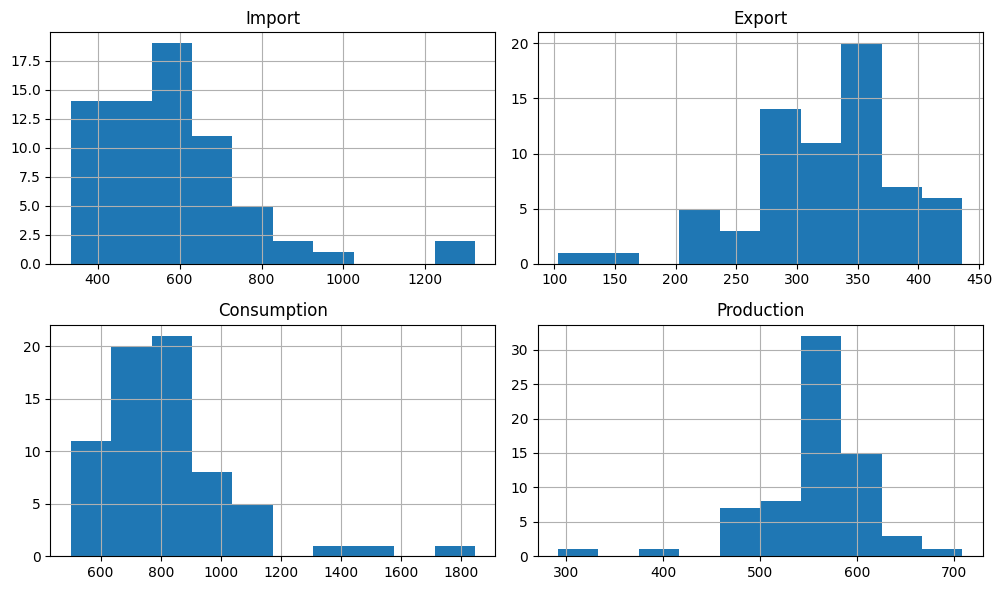

In [ ]:
import seaborn as sns
import numpy as np
# Plot histograms for 'Import', 'Export', and 'Consumption'
mean_df[['Import', 'Export', 'Consumption', 'Production']].hist(figsize=(10, 6))
plt.tight_layout()
plt.show()


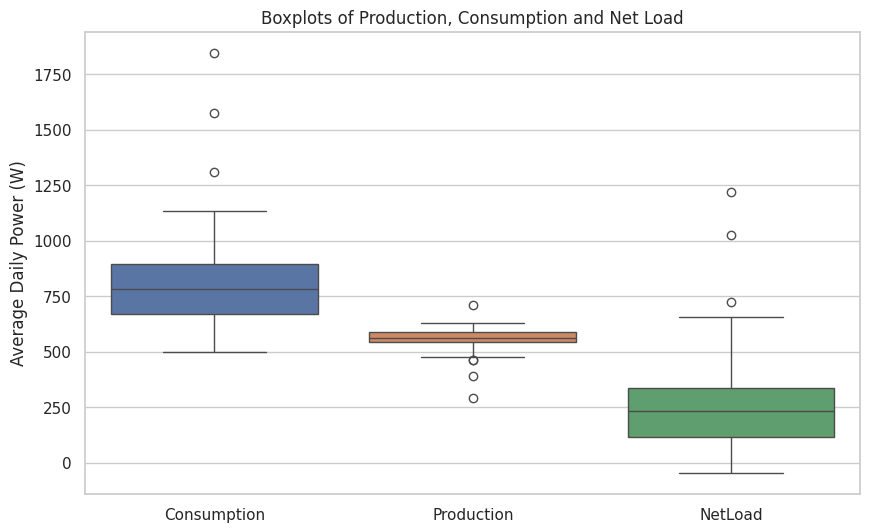

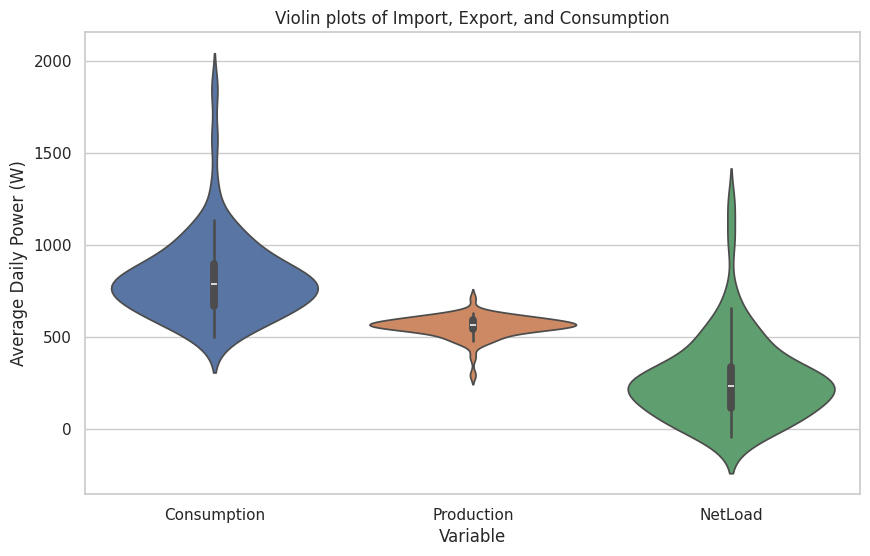

In [ ]:
# Set the style
sns.set(style="whitegrid")

# Plot boxplots for 'Import', 'Export', and 'Consumption'
plt.figure(figsize=(10, 6))
#sns.boxplot(data=mean_df[['Import', 'Export', 'Consumption','Production']])
sns.boxplot(data=mean_df[[ 'Consumption', 'Production','NetLoad']])
#sns.boxplot(data=mean_df[['Import_KWh', 'Export_KWh', 'Consumption_KWh','Production_KWh']])
#plt.xlabel('Variable')
plt.ylabel('Average Daily Power (W)')
#plt.ylabel('average daily KWh')
plt.title('Boxplots of Production, Consumption and Net Load')
plt.show()

# Plot violin plots for 'Import', 'Export', and 'Consumption'
plt.figure(figsize=(10, 6))
#sns.violinplot(data=mean_df[['Import', 'Export', 'Consumption', 'Production']], inner='quartile')
sns.violinplot(data=mean_df[['Consumption', 'Production',  'NetLoad']])
plt.xlabel('Variable')
plt.ylabel('Average Daily Power (W)')
plt.title('Violin plots of Import, Export, and Consumption')
plt.show()


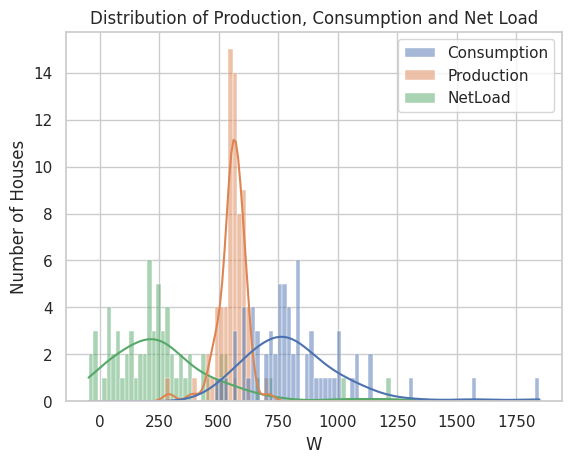

In [ ]:
# Set the style
sns.set(style="whitegrid")

# Plot histograms for 'Import', 'Export', and 'Consumption'
sns.histplot(data=mean_df[[ 'Consumption', 'Production','NetLoad']], bins=100, kde=True )
#sns.histplot(data=mean_df[['Import_KWh', 'Export_KWh', 'Consumption_KWh']], bins=68, kde=True)

plt.xlabel('W')
plt.ylabel('Number of Houses')
plt.title('Distribution of Production, Consumption and Net Load')
plt.show()

In [ ]:
# estimate the Total Power of each house
# group by PV_meter

#sum_df = combined_df.drop('Timestamp', axis=1)
sum_df = combined_df.groupby('PV_meter').agg({'Import':'sum', 'Export':'sum', 'Consumption':'sum', 'Production':'sum'}).reset_index()

# Add KWh columns??
sum_df['Import_KWh'] = sum_df['Import'] / (2000)
sum_df['Export_KWh'] = sum_df['Export'] / (2000)
sum_df['Consumption_KWh'] = sum_df['Consumption'] / (2000)
sum_df['Production_KWh'] = sum_df['Production'] / (2000)

sum_df.info()
sum_df.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PV_meter         68 non-null     int64  
 1   Import           68 non-null     float64
 2   Export           68 non-null     float64
 3   Consumption      68 non-null     float64
 4   Production       68 non-null     float64
 5   Import_KWh       68 non-null     float64
 6   Export_KWh       68 non-null     float64
 7   Consumption_KWh  68 non-null     float64
 8   Production_KWh   68 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 4.9 KB


PV_meter       Import      Export  Consumption   Production    Import_KWh  \
0        418  13576084.47  4519710.62  17610785.30   8554411.45   6788.042235   
1        420  12129841.83  4481026.26  17806579.37  10157763.80   6064.920915   
2        428   8935891.75  6980159.66  11577144.94   9621412.85   4467.945875   
3        433   8835305.41  6007569.91  13205397.11  10377661.61   4417.652705   
4        438  22148112.25  4104078.23  27657558.17   9613524.15  11074.056125   
5        466   8061888.50  5254215.11  12339313.55   9531640.16   4030.944250   
6        473   9771483.39  4800713.26  13861328.47   8890558.34   4885.741695   
7        474  13055342.40  4476297.60  17598709.26   9019664.46   6527.671200   
8        488  15064342.53  3659591.28  19693315.00   8288563.75   7532.171265   
9        490  11102577.32  6487556.53  13905717.49   9290696.70   5551.288660   
10       495   6822117.50  5823274.55  10606391.71   9607548.76   3411.058750   
11       504   9663368.80  5943958.40  13392861.64   9673451.24   4831.684400   
12       507  15089988.00  4939283.20  19829209.05   9678504.25   7544.994000   
13       508   9349036.00  3577004.00  16176707.54  10404675.54   4674.518000   
14       513   7376007.39  6135433.08  10649740.23   9409165.92   3688.003695   

     Export_KWh  Consumption_KWh  Production_KWh  
0   2259.855310      8805.392650     4277.205725  
1   2240.513130      8903.289685     5078.881900  
2   3490.079830      5788.572470     4810.706425  
3   3003.784955      6602.698555     5188.830805  
4   2052.039115     13828.779085     4806.762075  
5   2627.107555      6169.656775     4765.820080  
6   2400.356630      6930.664235     4445.279170  
7   2238.148800      8799.354630     4509.832230  
8   1829.795640      9846.657500     4144.281875  
9   3243.778265      6952.858745     4645.348350  
10  2911.637275      5303.195855     4803.774380  
11  2971.979200      6696.430820     4836.725620  
12  2469.641600      9914.604525     4839.252125  
13  1788.502000      8088.353770     5202.337770  
14  3067.716540      5324.870115     4704.582960

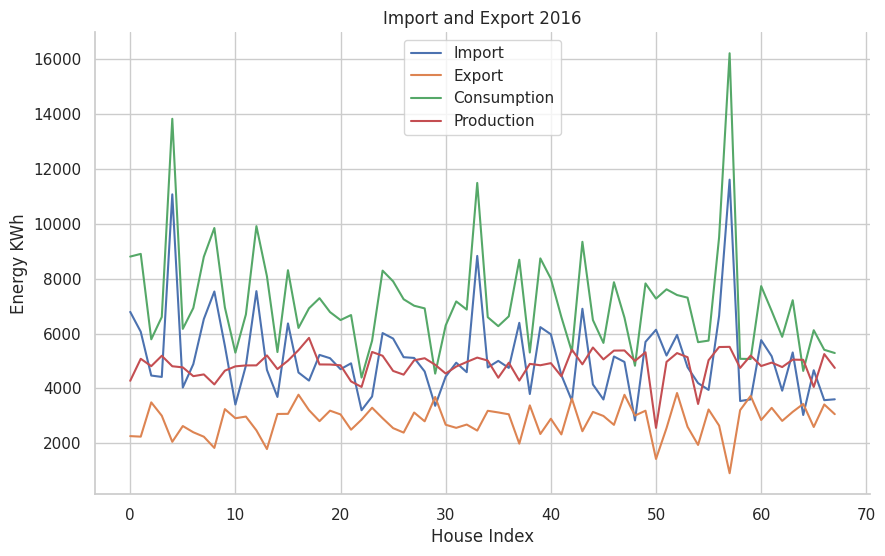

In [ ]:
plt.figure(figsize=(10, 6))
sum_df['Import_KWh'].plot(kind='line', title='Import and Export 2016')
sum_df['Export_KWh'].plot(kind='line')
sum_df['Consumption_KWh'].plot(kind='line')
sum_df['Production_KWh'].plot(kind='line')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(['Import', 'Export','Consumption','Production'])  # Add a legend to distinguish between the two lines
plt.xlabel('House Index')  # Add x-axis label if needed
plt.ylabel('Energy KWh')  # Add y-axis label if needed
plt.show()


# Mean house Yearly Load Analysis
* Prod,Cons,Net Profiles yearly


In [ ]:
# Take the average of each timestamp
yearday_df = combined_df.groupby(['Timestamp', 'month']).mean().reset_index()
#yearday_df = combined_df.groupby(['Timestamp', 'month']).sum().reset_index()
yearday_df.info()
yearday_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    17564 non-null  datetime64[ns]
 1   month        17564 non-null  int32         
 2   NM_meter     17564 non-null  float64       
 3   Import       17564 non-null  float64       
 4   Export       17564 non-null  float64       
 5   PV_meter     17564 non-null  float64       
 6   Production   17564 non-null  float64       
 7   Consumption  17564 non-null  float64       
 8   NetLoad      17564 non-null  float64       
 9   day          17564 non-null  float64       
 10  day_of_week  17564 non-null  float64       
 11  year         17564 non-null  float64       
 12  hour_of_day  17564 non-null  float64       
 13  quarter      17564 non-null  float64       
dtypes: datetime64[ns](1), float64(12), int32(1)
memory usage: 1.8 MB


Timestamp  month    NM_meter       Import  Export    PV_meter  \
0 2016-01-01 00:00:00      1  614.941176  1034.182794     0.0  586.632353   
1 2016-01-01 00:30:00      1  614.941176   892.905882     0.0  586.632353   
2 2016-01-01 01:00:00      1  614.941176   995.311765     0.0  586.632353   
3 2016-01-01 01:30:00      1  614.941176   855.753088     0.0  586.632353   
4 2016-01-01 02:00:00      1  614.941176   828.964706     0.0  586.632353   

   Production  Consumption      NetLoad  day  day_of_week    year  \
0         0.0  1034.182794  1034.182794  1.0          4.0  2016.0   
1         0.0   892.905882   892.905882  1.0          4.0  2016.0   
2         0.0   995.311765   995.311765  1.0          4.0  2016.0   
3         0.0   855.753088   855.753088  1.0          4.0  2016.0   
4         0.0   828.964706   828.964706  1.0          4.0  2016.0   

   hour_of_day  quarter  
0          0.0      1.0  
1          0.0      1.0  
2          1.0      1.0  
3          1.0      1.0  
4          2.0      1.0

In [ ]:
# Remove multiple columns
avg_energy_df = yearday_df.drop(columns=['month', 'NM_meter', 'Import','Export', 'PV_meter',
                                         'day','day_of_week','year','hour_of_day','quarter'])

# Export the DataFrame to a CSV file
#avg_energy_df.to_csv('Average_household_energy.csv', index=False)  # Set index=False to not save row indices in the file

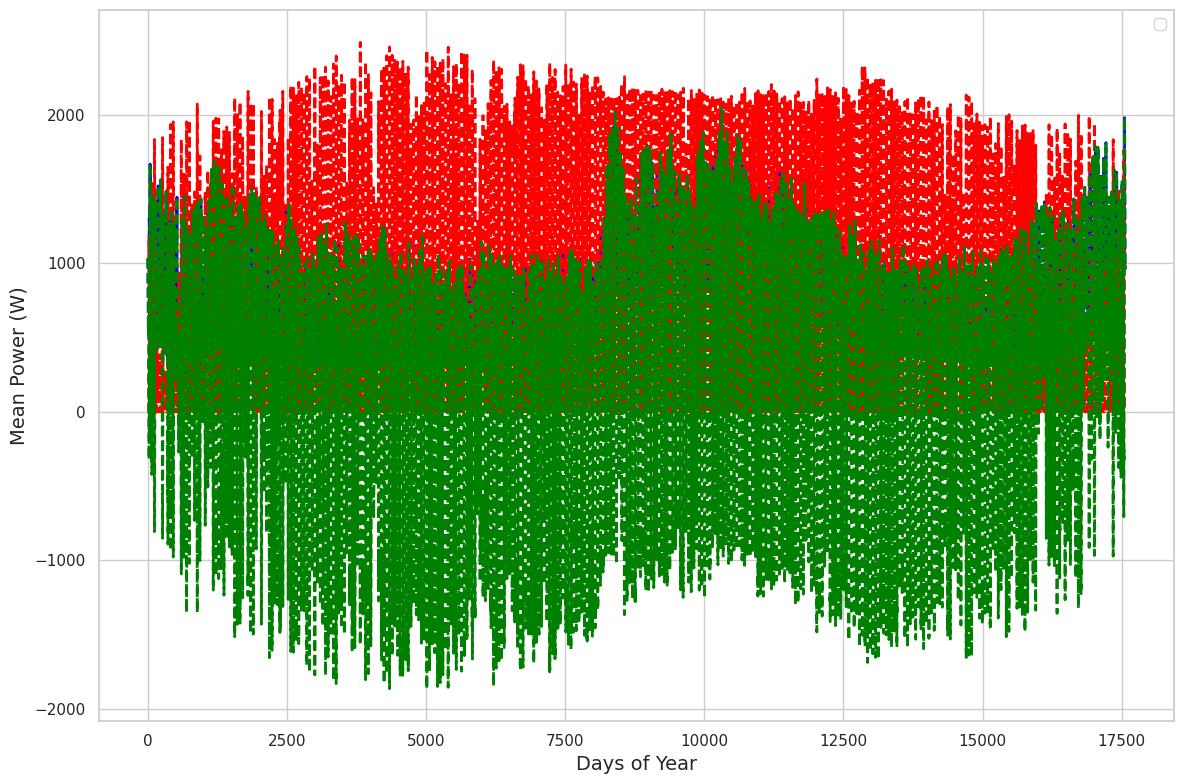

In [ ]:
# Plot Prod, Cons and Net vs days
plt.figure(figsize=(12, 8))
plt.plot( yearday_df['Consumption'], linestyle='--',linewidth=2, color='blue')
plt.plot( yearday_df['Production'], linestyle='--',linewidth=2, color='red')
plt.plot( yearday_df['NetLoad'],  linestyle='--',linewidth=2, color='green')

# Set the labels and title
plt.xlabel('Days of Year',  fontsize=14)
plt.ylabel('Mean Power (W)',  fontsize=14)
plt.legend( labels=['Consumption', 'Production', 'NetLoad'])
plt.legend()
plt.tight_layout()  # Auto-adjust layout to prevent clipping of labels

# Show the plot
plt.show()

In [ ]:
# Assuming your DataFrame is named df and has a column named 'Timestamp'
# Set the 'Timestamp' column as the index if it's not already
yearday_df.set_index('Timestamp', inplace=True)

# Resample the DataFrame to group rows into 48-row chunks and calculate the mean
avg365_df = yearday_df.resample('24H').mean().reset_index()
avg365_df.info()
avg365_df.head(400)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    366 non-null    datetime64[ns]
 1   month        366 non-null    float64       
 2   NM_meter     366 non-null    float64       
 3   Import       366 non-null    float64       
 4   Export       366 non-null    float64       
 5   PV_meter     366 non-null    float64       
 6   Production   366 non-null    float64       
 7   Consumption  366 non-null    float64       
 8   NetLoad      366 non-null    float64       
 9   day          366 non-null    float64       
 10  day_of_week  366 non-null    float64       
 11  year         366 non-null    float64       
 12  hour_of_day  366 non-null    float64       
 13  quarter      366 non-null    float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 40.2 KB


Timestamp  month    NM_meter      Import      Export    PV_meter  \
0   2016-01-01    1.0  615.078424  831.250405  125.203799  587.073380   
1   2016-01-02    1.0  614.897667  790.017105  127.614370  586.969888   
2   2016-01-03    1.0  614.861342  734.761010  210.306044  586.877950   
3   2016-01-04    1.0  614.954991  927.325082   15.378734  586.761308   
4   2016-01-05    1.0  615.016389  921.349928   10.405112  586.689338   
..         ...    ...         ...         ...         ...         ...   
361 2016-12-27   12.0  615.077610  783.798518  189.718283  587.435594   
362 2016-12-28   12.0  615.066644  854.536682   96.305430  587.591846   
363 2016-12-29   12.0  615.066379  795.920935  116.064742  587.490509   
364 2016-12-30   12.0  614.852729  806.616977  138.199725  587.699517   
365 2016-12-31   12.0  615.239726  879.695541  196.746132  587.680794   

     Production  Consumption     NetLoad   day  day_of_week    year  \
0    278.248585   984.295191  706.046606   1.0          4.0  2016.0   
1    308.540305   970.943041  662.402736   2.0          5.0  2016.0   
2    404.087828   928.542794  524.454966   3.0          6.0  2016.0   
3     77.903214   989.849563  911.946349   4.0          0.0  2016.0   
4     73.168270   984.113086  910.944816   5.0          1.0  2016.0   
..          ...          ...         ...   ...          ...     ...   
361  365.667594   959.747829  594.080235  27.0          1.0  2016.0   
362  231.628714   989.859966  758.231252  28.0          2.0  2016.0   
363  263.642366   943.498559  679.856193  29.0          3.0  2016.0   
364  289.433610   957.850862  668.417252  30.0          4.0  2016.0   
365  399.420882  1082.370291  682.949409  31.0          5.0  2016.0   

     hour_of_day  quarter  
0           11.5      1.0  
1           11.5      1.0  
2           11.5      1.0  
3           11.5      1.0  
4           11.5      1.0  
..           ...      ...  
361         11.5      4.0  
362         11.5      4.0  
363         11.5      4.0  
364         11.5      4.0  
365         11.5      4.0  

[366 rows x 14 columns]

In [ ]:
remove_cols = ['Timestamp', 'day','year','hour_of_day' , 'NM_meter','PV_meter', 'Import','Export']
### Use the `drop()` method to remove the columns
avg365_df = avg365_df.drop(columns=remove_cols)

In [ ]:
# Calculate moving average profiles for each cluster
window_size = 20  # 20 days
moving_avg_df = avg365_df.rolling(window=window_size, min_periods=1).mean()
moving_avg_df.info()
moving_avg_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        366 non-null    float64
 1   Production   366 non-null    float64
 2   Consumption  366 non-null    float64
 3   NetLoad      366 non-null    float64
 4   day_of_week  366 non-null    float64
 5   quarter      366 non-null    float64
dtypes: float64(6)
memory usage: 17.3 KB


month  Production  Consumption     NetLoad  day_of_week  quarter
0    1.0  278.248585   984.295191  706.046606         4.00      1.0
1    1.0  293.394445   977.619116  684.224671         4.50      1.0
2    1.0  330.292240   961.260342  630.968102         5.00      1.0
3    1.0  267.194983   968.407647  701.212664         3.75      1.0
4    1.0  228.389641   971.548735  743.159094         3.20      1.0

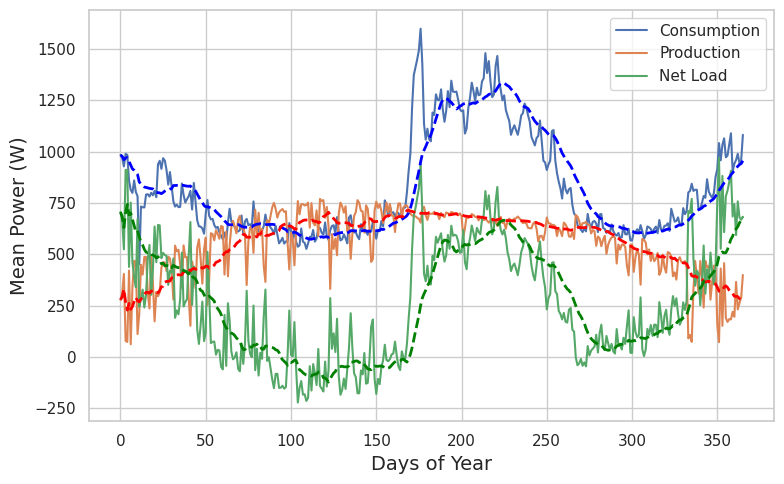

In [ ]:
# Plot cluster labels vs months
plt.figure(figsize=(8, 5))
plt.plot( avg365_df['Consumption'], linestyle='-', label='Consumption')
plt.plot( avg365_df['Production'], linestyle='-', label='Production')
plt.plot( avg365_df['NetLoad'],  linestyle='-', label='Net Load')

plt.plot( moving_avg_df['Consumption'], linestyle='--',linewidth=2, color='blue')
plt.plot( moving_avg_df['Production'], linestyle='--',linewidth=2, color='red')
plt.plot( moving_avg_df['NetLoad'],  linestyle='--',linewidth=2, color='green')

# Set the labels and title
plt.xlabel('Days of Year',  fontsize=14)
plt.ylabel('Mean Power (W)',  fontsize=14)
#plt.title('Mean distribution of Consumption and Production by day (W)')
#plt.legend( labels=['Consumption', 'Production', 'NetLoad'])
plt.legend( labels=['Consumption', 'Production', 'NetLoad'])
plt.legend()
plt.tight_layout()  # Auto-adjust layout to prevent clipping of labels

# Show the plot
plt.show()

In [ ]:
#### Interactive Graphs
import plotly.graph_objects as go
from plotly.offline import plot

# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=avg365_df.index, y=avg365_df['Consumption'], mode='lines', name='Consumption'))
fig.add_trace(go.Scatter(x=avg365_df.index, y=avg365_df['Production'], mode='lines', name='Production'))
fig.add_trace(go.Scatter(x=avg365_df.index, y=avg365_df['NetLoad'], mode='lines', name='Net Load'))

fig.add_trace(go.Scatter(x=moving_avg_df.index, y=moving_avg_df['Consumption'], mode='lines', name='Filtered Consumption', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=moving_avg_df.index, y=moving_avg_df['Production'], mode='lines', name='Filtered Production', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=moving_avg_df.index, y=moving_avg_df['NetLoad'], mode='lines', name='Filtered Net Load', line=dict(dash='dash')))

# Update layout
fig.update_layout(
    title='Mean distribution of Consumption and Production by day (W)',
    xaxis_title='Days',
    yaxis_title='Mean Consumption (W)',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

# Save the figure to an HTML file
plot(fig, filename='interactive_plot.html')

'interactive_plot.html'

### Cluster houses based on Consumption
To see whether there are differences between
Consumptions

In [ ]:
## Yearly analysis
### group by TimeStamp
### estimate means
yearly_df = combined_df.groupby(['Timestamp', 'PV_meter']).mean().reset_index()
yearly_df.info()
#yearly_df.head(68)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187290 entries, 0 to 1187289
Data columns (total 14 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Timestamp    1187290 non-null  datetime64[ns]
 1   PV_meter     1187290 non-null  int64         
 2   NM_meter     1187290 non-null  float64       
 3   Import       1187290 non-null  float64       
 4   Export       1187290 non-null  float64       
 5   Production   1187290 non-null  float64       
 6   Consumption  1187290 non-null  float64       
 7   NetLoad      1187290 non-null  float64       
 8   day          1187290 non-null  float64       
 9   day_of_week  1187290 non-null  float64       
 10  month        1187290 non-null  float64       
 11  year         1187290 non-null  float64       
 12  hour_of_day  1187290 non-null  float64       
 13  quarter      1187290 non-null  float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 126.8 MB

In [ ]:
pivot_df = yearly_df.pivot(index='Timestamp', columns='PV_meter', values='Consumption').transpose()
#pivot_df = combined_df.pivot(index='Timestamp', columns='PV_meter', values='Consumption')
pivot_df.info()
pivot_df.head(100)

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 418 to 770
Columns: 17564 entries, 2016-01-01 00:00:00 to 2016-12-31 23:30:00
dtypes: float64(17564)
memory usage: 9.1 MB


Timestamp  2016-01-01 00:00:00  2016-01-01 00:30:00  2016-01-01 01:00:00  \
PV_meter                                                                   
418                      79.32               166.05               168.47   
420                     653.28               628.51               535.59   
428                     140.00               242.39               214.88   
433                    1429.30               386.46               915.24   
438                     679.58               649.61               663.08   
...                        ...                  ...                  ...   
741                     600.67               444.16               536.19   
747                    2695.20              2408.80              2055.20   
748                     797.38              2064.20              2148.10   
749                    1030.10               867.60               978.54   
770                     283.20               384.00               376.00   

Timestamp  2016-01-01 01:30:00  2016-01-01 02:00:00  2016-01-01 02:30:00  \
PV_meter                                                                   
418                     199.78               121.37                75.23   
420                     464.96               416.68               399.79   
428                     322.31               233.24               374.33   
433                     504.24               258.15               272.26   
438                     750.03               519.87               572.28   
...                        ...                  ...                  ...   
741                     762.08               244.12               371.42   
747                    2840.80               774.40               239.20   
748                    1941.00              2269.40              2174.90   
749                     907.13               710.96               697.50   
770                     260.00               304.00               507.20   

Timestamp  2016-01-01 03:00:00  2016-01-01 03:30:00  2016-01-01 04:00:00  \
PV_meter                                                                   
418                     142.59                67.77              1252.90   
420                     393.60               319.64               435.05   
428                     167.75               274.04               171.69   
433                     173.09               226.46               218.35   
438                     498.67               542.75               393.83   
...                        ...                  ...                  ...   
741                     389.54              1485.30               265.39   
747                     284.00               266.40               260.00   
748                    1949.50               787.06               136.62   
749                     563.55               389.98               162.28   
770                     436.00               327.20               373.60   

Timestamp  2016-01-01 04:30:00  ...  2016-12-31 19:00:00  2016-12-31 19:30:00  \
PV_meter                        ...                                             
418                    1417.70  ...              2368.80              4556.60   
420                     319.45  ...              6267.60              4887.90   
428                     354.62  ...              1793.50              2480.30   
433                     170.20  ...              1230.70              2377.50   
438                     465.24  ...              2575.80              4730.00   
...                        ...  ...                  ...                  ...   
741                     157.32  ...              1784.90              2055.90   
747                     255.20  ...              1430.40              1232.00   
748                     137.07  ...              5560.70              2711.20   
749                     208.47  ...               459.61               434.22   
770                     287.20  ...               794.40     

In [ ]:
# Preprocess the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df.fillna(0))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Number of households in each cluster:
Cluster
2    47
1    19
0     2
Name: count, dtype: int64


<ipython-input-32-bc3b4e28dc2b>:20: FutureWarning:

Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead



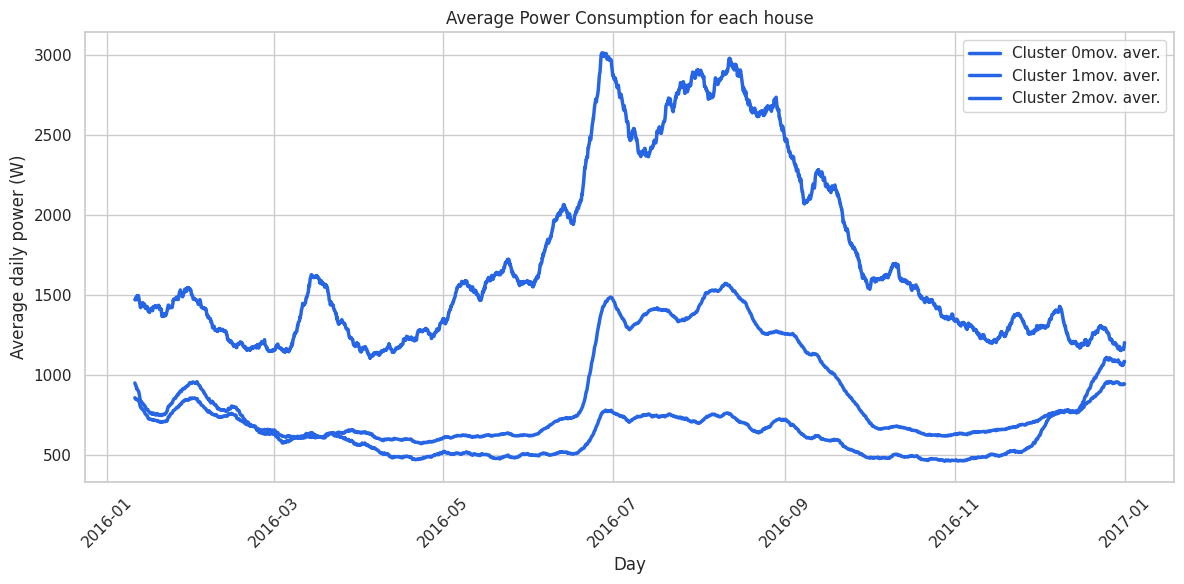

Done


In [ ]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

# Assign cluster labels
cluster_labels = kmeans.labels_
pivot_df['Cluster'] = cluster_labels

# Analyze the clustering results
cluster_counts = pivot_df['Cluster'].value_counts()
print("Number of households in each cluster:")
print(cluster_counts)

# Calculate the average consumption for each cluster
cluster_means = pivot_df.groupby('Cluster').mean()

# Calculate moving average profiles for each cluster
#window_size = 1*48  # Example window size of 48 half-hour periods
window_size = 10*48
moving_avg_df = cluster_means.rolling(window=window_size, axis=1).mean()

# Plotting
plt.figure(figsize=(12, 6))

for cluster in range(len(cluster_counts)):
    # plt.plot(cluster_means.columns, cluster_means.loc[cluster], label=f'Cluster {cluster}')
     plt.plot(moving_avg_df.columns, moving_avg_df.loc[cluster], label=f'Cluster {cluster}' + 'mov. aver.',
              linewidth=2.5, color = (0.15 ,0.4, 0.9))

plt.xlabel('Day')
plt.ylabel('Average daily power (W)')
plt.title('Average Power Consumption for each house')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show(block=True)

print("Done")

In [ ]:
cluster_means.info()
cluster_means.head()


<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 0 to 2
Columns: 17564 entries, 2016-01-01 00:00:00 to 2016-12-31 23:30:00
dtypes: float64(17564)
memory usage: 411.7 KB


Timestamp  2016-01-01 00:00:00  2016-01-01 00:30:00  2016-01-01 01:00:00  \
Cluster                                                                    
0                   934.490000           974.255000           995.040000   
1                  1407.477895          1155.666842          1390.851579   
2                   887.518511           783.221702           835.424255   

Timestamp  2016-01-01 01:30:00  2016-01-01 02:00:00  2016-01-01 02:30:00  \
Cluster                                                                    
0                  1167.115000           981.085000           821.440000   
1                  1176.419474          1080.714211           982.244211   
2                   712.872553           720.720426           798.264681   

Timestamp  2016-01-01 03:00:00  2016-01-01 03:30:00  2016-01-01 04:00:00  \
Cluster                                                                    
0                   964.985000           703.565000           900.615000   
1                  1058.708947           808.880526           846.944211   
2                   598.516170           582.973191           446.458723   

Timestamp  2016-01-01 04:30:00  ...  2016-12-31 19:00:00  2016-12-31 19:30:00  \
Cluster                         ...                                             
0                   727.690000  ...          2591.350000          3224.900000   
1                   747.574737  ...          2175.754211          2209.515263   
2                   426.711277  ...          1795.327447          1623.085106   

Timestamp  2016-12-31 20:00:00  2016-12-31 20:30:00  2016-12-31 21:00:00  \
Cluster                                                                    
0                  3209.335000          3849.340000          3499.295000   
1                  1735.370000          1788.294737          1870.543158   
2                  1604.851064          1540.144468          1397.833191   

Timestamp  2016-12-31 21:30:00  2016-12-31 22:00:00  2016-12-31 22:30:00  \
Cluster                                                                    
0                  2931.225000          2487.365000          1697.945000   
1                  1779.041579          1608.840526          1405.746842   
2                  1136.025532          1060.073830           990.387447   

Timestamp  2016-12-31 23:00:00  2016-12-31 23:30:00  
Cluster                                              
0                  1693.360000          1716.845000  
1                  1094.475263          1254.127895  
2                   878.925106           856.968723  

[3 rows x 17564 columns]

In [ ]:
cluster_labels = kmeans.predict(scaled_data)
cluster_labels


array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 1, 2, 1, 2,
       1, 1], dtype=int32)

# Monthly Analysis

In [ ]:
## Seasonal Analysis - Monthly

#monthly_df = combined_df.groupby(['month','PV_meter']).mean().reset_index()
monthly_df = combined_df.groupby(['month']).mean()
monthly_df.info()
monthly_df.head(100)

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 1 to 12
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    12 non-null     datetime64[ns]
 1   NM_meter     12 non-null     float64       
 2   Import       12 non-null     float64       
 3   Export       12 non-null     float64       
 4   PV_meter     12 non-null     float64       
 5   Production   12 non-null     float64       
 6   Consumption  12 non-null     float64       
 7   NetLoad      12 non-null     float64       
 8   day          12 non-null     float64       
 9   day_of_week  12 non-null     float64       
 10  year         12 non-null     float64       
 11  hour_of_day  12 non-null     float64       
 12  quarter      12 non-null     float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 1.3 KB


Timestamp    NM_meter      Import      Export  \
month                                                                     
1     2016-01-16 11:41:13.716228352  614.887308  685.900518  183.411376   
2     2016-02-15 11:46:44.422108416  614.795661  534.835408  295.428397   
3     2016-03-16 11:25:36.160033536  614.781559  436.975821  390.451203   
4     2016-04-15 23:45:38.815038720  614.831138  359.350618  446.965081   
5     2016-05-16 11:50:34.403464192  614.773401  381.062915  410.401528   
6     2016-06-16 00:00:46.986989056  614.991968  623.333343  383.608100   
7     2016-07-16 11:43:36.344154368  615.021728  874.040418  318.826937   
8     2016-08-16 11:42:36.456870144  615.008243  880.121039  309.835451   
9     2016-09-15 23:46:44.429660672  614.936093  594.464826  367.451929   
10    2016-10-16 11:53:26.682568192  614.969418  426.147388  347.679603   
11    2016-11-16 00:11:26.510066432  615.253178  494.037611  272.791852   
12    2016-12-16 11:54:35.777180160  615.065264  753.259973  154.812093   

         PV_meter  Production  Consumption     NetLoad        day  \
month                                                               
1      586.869068  342.411569   844.900710  502.489141  15.997167   
2      586.996483  468.570809   707.977820  239.407011  15.000924   
3      587.120205  592.537856   639.062475   46.524619  15.985597   
4      587.109665  673.464813   585.850350  -87.614463  15.500057   
5      587.102981  641.992640   612.654028  -29.338612  16.003574   
6      586.872667  701.251314   940.976557  239.725243  15.510685   
7      586.797243  684.724016  1239.937497  555.213481  15.998871   
8      586.819881  657.861691  1228.147279  570.285588  15.998266   
9      586.795282  625.140047   852.152944  227.012896  15.501100   
10     586.833134  543.220901   621.688686   78.467785  16.006275   
11     587.702712  434.835510   656.081269  221.245759  15.518004   
12     587.446560  299.548388   897.996268  598.447879  16.006529   

       day_of_week    year  hour_of_day  quarter  
month                                             
1         3.195712  2016.0    11.505099      1.0  
2         2.896779  2016.0    11.506789      1.0  
3         2.899730  2016.0    11.522750      1.0  
4         3.101625  2016.0    11.509433      2.0  
5         2.935344  2016.0    11.507172      2.0  
6         2.967145  2016.0    11.506587      2.0  
7         3.193933  2016.0    11.503862      3.0  
8         2.805912  2016.0    11.501739      3.0  
9         3.033263  2016.0    11.502625      3.0  
10        3.069349  2016.0    11.490147      4.0  
11        2.902351  2016.0    11.508605      4.0  
12        3.099411  2016.0    11.503225      4.0

In [ ]:
cluster_labels = 4
# Array containing the months
months_of_the_year = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
# Print the array
print(months_of_the_year)

['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


"\n# Plot cluster labels vs months\nplt.figure(figsize=(10, 6))\nplt.plot(months_of_the_year, monthly_df['Consumption'], marker='o', linestyle='-', label='Consumption')\nplt.plot(months_of_the_year, monthly_df['Production'], marker='o', linestyle='-', label='Production')\nplt.plot(months_of_the_year, monthly_df['NetLoad'], marker='o', linestyle='-', label='Net Load')\n# Set the labels and title\nplt.xlabel('Month')\nplt.ylabel('Mean Consumption (W)')\nplt.title('Mean distribution of Consumption and Production by Month by Month (W)')\n#plt.legend( labels=['Consumption', 'Production', 'NetLoad'])\nplt.legend( labels=['Consumption', 'Production', 'NetLoad'])\nplt.legend()\n# Show the plot\nplt.show()\n"

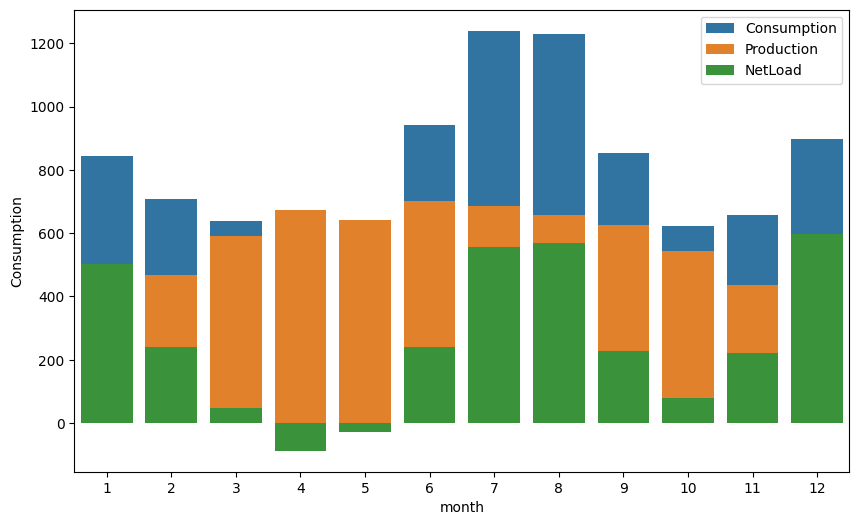

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x='month', y='Consumption', data=monthly_df, label='Consumption')
sns.barplot(x='month', y='Production', data=monthly_df, label='Production')
sns.barplot(x='month', y='NetLoad', data=monthly_df, label='NetLoad')

'''
# Plot cluster labels vs months
plt.figure(figsize=(10, 6))
plt.plot(months_of_the_year, monthly_df['Consumption'], marker='o', linestyle='-', label='Consumption')
plt.plot(months_of_the_year, monthly_df['Production'], marker='o', linestyle='-', label='Production')
plt.plot(months_of_the_year, monthly_df['NetLoad'], marker='o', linestyle='-', label='Net Load')
# Set the labels and title
plt.xlabel('Month')
plt.ylabel('Mean Consumption (W)')
plt.title('Mean distribution of Consumption and Production by Month by Month (W)')
#plt.legend( labels=['Consumption', 'Production', 'NetLoad'])
plt.legend( labels=['Consumption', 'Production', 'NetLoad'])
plt.legend()
# Show the plot
plt.show()
'''


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



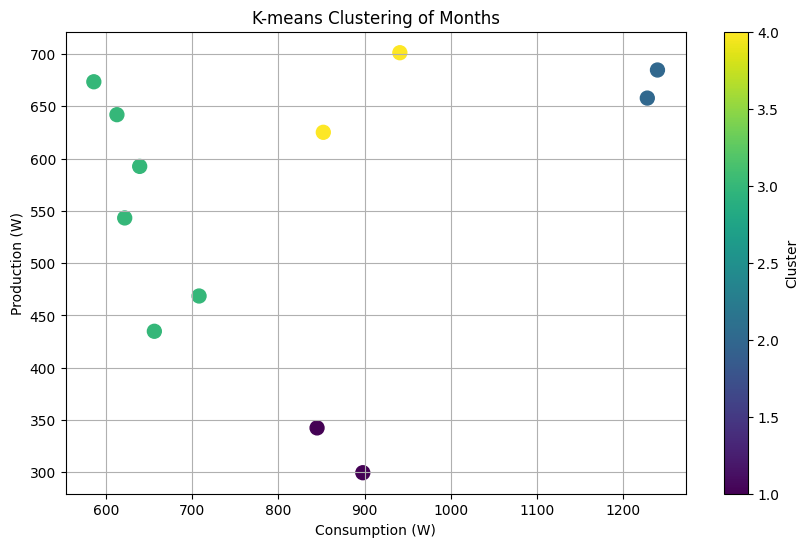

In [ ]:
# Cluster months / seasons
# Extract features for clustering
features = monthly_df[['Consumption', 'Production']]

# Standardize the features
#scaler = StandardScaler()
#scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters (e.g., using the elbow method)
# Example code:
# elbow_method()

# Apply K-means clustering
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(features)
cluster_labels = kmeans.labels_ +1

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(features['Consumption'], features['Production'], c=cluster_labels, cmap='viridis', s=100)
plt.xlabel('Consumption (W)')
plt.ylabel('Production (W)')
plt.title('K-means Clustering of Months')
plt.colorbar(label='Cluster')
plt.grid(True)  # Add grid
plt.show()

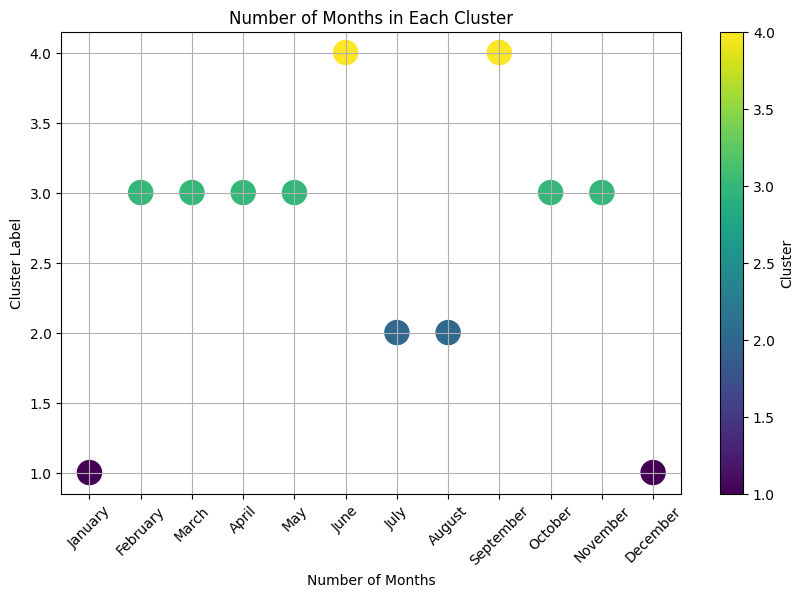

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot cluster labels vs months
plt.scatter(months_of_the_year, cluster_labels , c=cluster_labels, cmap='viridis', s=300)
# Set the labels and title
plt.ylabel('Cluster Label')
plt.xlabel('Number of Months')
plt.title('Number of Months in Each Cluster')
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
# Show the color bar
plt.colorbar(label='Cluster')
# Show the plot
plt.grid(True)  # Add grid
plt.show()

# Hourly analysis

day number: 269


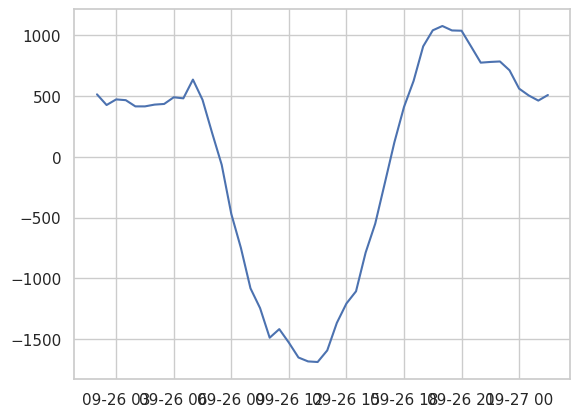

In [ ]:
#Plot a random day in the year
import random
random_number = random.randint(1, 356)
print("day number:",random_number)

day_nr = random_number
#plt.plot(yearday_df['Consumption'].iloc[48*1*week_nr:48*1*(week_nr+1)])
plt.plot(yearday_df['NetLoad'].iloc[48*1*day_nr:48*1*(day_nr+1)])

In [ ]:
#combined_df['hour_of_day'] = combined_df['Timestamp'].dt.hour

hourly_df = combined_df.groupby(['hour_of_day']).mean()
hourly_df.info()
hourly_df.head(100)

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 23
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    24 non-null     datetime64[ns]
 1   NM_meter     24 non-null     float64       
 2   Import       24 non-null     float64       
 3   Export       24 non-null     float64       
 4   PV_meter     24 non-null     float64       
 5   Production   24 non-null     float64       
 6   Consumption  24 non-null     float64       
 7   NetLoad      24 non-null     float64       
 8   day          24 non-null     float64       
 9   day_of_week  24 non-null     float64       
 10  month        24 non-null     float64       
 11  year         24 non-null     float64       
 12  quarter      24 non-null     float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 2.5 KB


Timestamp    NM_meter       Import  \
hour_of_day                                                          
0           2016-07-01 12:19:54.201908480  614.937720   813.436257   
1           2016-07-01 13:19:54.201908480  614.937720   738.655241   
2           2016-07-01 14:19:54.201908736  614.937720   677.321740   
3           2016-07-02 05:33:41.460572672  614.937720   620.815786   
4           2016-07-01 16:19:54.201908736  614.937720   578.202838   
5           2016-07-01 17:19:54.201908480  614.937720   581.704609   
6           2016-07-02 00:40:38.207860736  614.937710   635.651841   
7           2016-07-01 18:58:31.372311296  614.979016   627.029201   
8           2016-07-01 21:53:41.667628288  614.916083   403.187765   
9           2016-07-01 09:07:49.427542528  615.501490   246.177568   
10          2016-07-01 13:49:54.518180096  615.273803   181.783980   
11          2016-07-01 16:11:52.429769472  614.810113   160.843766   
12          2016-07-01 18:43:51.710286080  614.595293   175.038689   
13          2016-07-01 20:24:28.629318144  614.601054   201.151529   
14          2016-07-01 18:09:15.430029312  614.846392   220.399959   
15          2016-07-01 18:32:56.727802624  614.946293   292.293490   
16          2016-07-01 21:35:23.159915264  615.040832   407.998377   
17          2016-07-02 03:46:05.441694720  614.955418   577.710678   
18          2016-07-02 06:16:03.723380736  614.926823   795.274492   
19          2016-07-02 07:19:55.937719552  614.937720   982.755724   
20          2016-07-02 08:19:55.937719808  614.937720  1109.606073   
21          2016-07-02 09:19:55.937719808  614.937720  1098.838029   
22          2016-07-02 10:15:00.000000000  614.941176  1019.150206   
23          2016-07-02 11:24:51.923494144  614.934263   928.699425   

                  Export    PV_meter   Production  Consumption      NetLoad  \
hour_of_day                                                                   
0               0.000000  586.632426     0.000000   813.436257   813.436257   
1               0.000000  586.632426     0.000000   738.655241   738.655241   
2               0.000000  586.632426     0.000000   677.321740   677.321740   
3               0.000000  586.632426     0.000000   620.815786   620.815786   
4               0.000000  586.632426     0.000000   578.202838   578.202838   
5               0.000000  586.632426     0.000506   581.705116   581.704609   
6               0.094728  586.632426     7.755037   643.312150   635.557113   
7              16.571846  587.377078   119.693200   730.150556   610.457356   
8             199.912830  588.893022   507.291613   710.566549   203.274935   
9             583.284803  589.020531  1037.390528   700.283293  -337.107235   
10            938.676727  588.224397  1476.338669   719.445921  -756.892748   
11           1178.337203  587.320577  1767.701325   750.207887 -1017.493437   
12           1256.095150  587.063745  1894.258987   813.202526 -1081.056461   
13           1200.306570  586.948759  1865.480533   866.325492  -999.155041   
14           1026.451736  587.013120  1674.826957   868.775180  -806.051777   
15            737.770219  587.054577  1355.473119   909.996391  -445.476728   
16            441.062303  586.951551   941.584964   908.521038   -33.063926   
17            193.175542  586.830591   525.929845   910.464980   384.535136   
18             37.941725  586.739609   204.645655   961.978422   757.332767   
19              1.377804  586.632426    42.730940  1024.108860   981.377920   
20              0.000868  586.632426     2.006273  1111.611478  1109.605205   
21              0.000000  586.632426     0.004817  1098.842847  1098.838029   
22              0.000000  586.632353     0.000000  1019.150206  1019.150206   
23              0.000000  586.632499     0.000000   928.699425   928.699425   

                   day  day_of_week     month    year   quarter  
hour_of_day                                                      
0            15.756866  

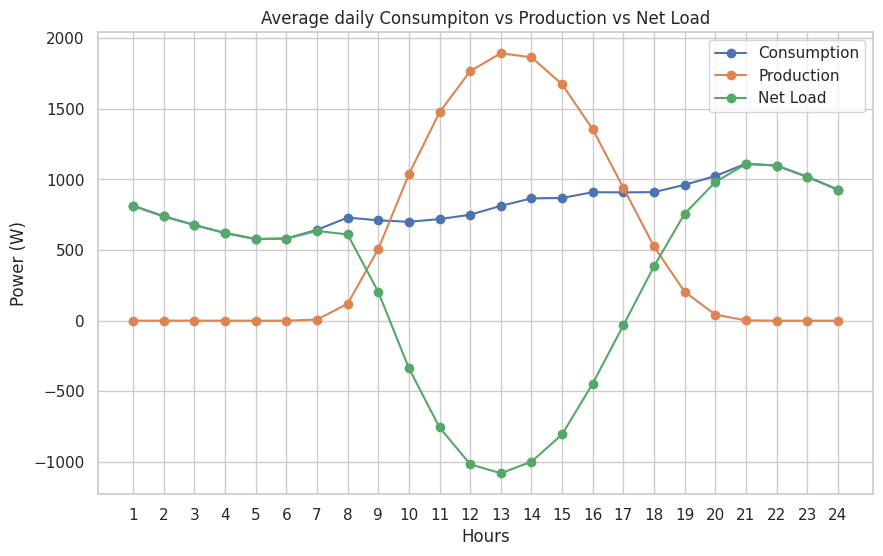

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))
hours = list(range(1, 25))

# Plot cluster labels vs months
plt.plot(hours, hourly_df['Consumption'], marker='o', linestyle='-', label='Consumption')
plt.plot(hours, hourly_df['Production'], marker='o', linestyle='-', label='Production')
plt.plot(hours, hourly_df['NetLoad'], marker='o', linestyle='-', label='Net Load')

# Set the labels and title
plt.xlabel('Hours')
plt.ylabel('Power (W)')
plt.title('Average daily Consumpiton vs Production vs Net Load')
plt.legend()
# Set custom x-axis tick labels
plt.xticks(hours)
# Show the plot
plt.show()

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Create a Plotly figure
fig = go.Figure()

# Add traces for each line plot
fig.add_trace(go.Scatter(x=hours, y=hourly_df['Consumption'], mode='lines+markers', name='Consumption'))
fig.add_trace(go.Scatter(x=hours, y=hourly_df['Production'], mode='lines+markers', name='Production'))
fig.add_trace(go.Scatter(x=hours, y=hourly_df['NetLoad'], mode='lines+markers', name='Net Load'))

# Update layout
fig.update_layout(title='Average daily Consumption, Production, and Net Load vs Hours',
                  xaxis_title='Hours',
                  yaxis_title='Power (W)',
                  showlegend=True)

# Show the plot
fig.show()

# Export the graph to an HTML file
pio.write_html(fig, 'plotly_graph.html')

###### Do the hourly for different months???

# Weekdays & Weekends

week number: 37


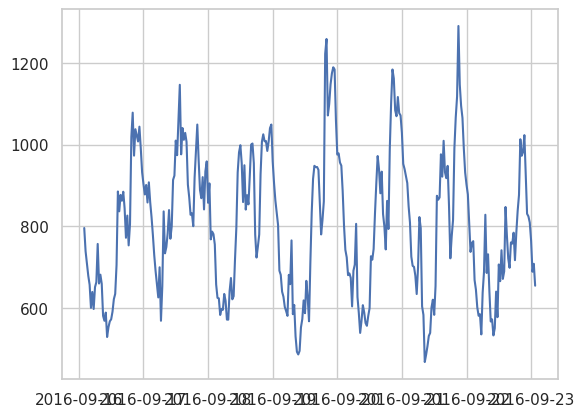

In [ ]:
#Plot a random week
import random
random_number = random.randint(1, 52)
print("week number:",random_number)

week_nr = random_number
#plt.plot(yearday_df['Timestamp'].iloc[48*7*week_nr:48*7*(week_nr+1)])
plt.plot(yearday_df['Consumption'].iloc[48*7*week_nr:48*7*(week_nr+1)])
#plt.plot(yearday_df['NetLoad'].iloc[48*7*week_nr:48*7*(week_nr+1)])

In [ ]:
## Seasonal Analysis - Weekly
combined_df2 = combined_df
combined_df2['day_type'] = combined_df2['Timestamp'].dt.dayofweek.apply(lambda x: 'Weekend' if x > 4 else 'Weekday')

weekly_df = combined_df2.groupby(['quarter','day_type']).mean()
#weekly_df = combined_df2.groupby(['day_of_week']).mean()
weekly_df.info()
weekly_df.head(100)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8 entries, (1, 'Weekday') to (4, 'Weekend')
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    8 non-null      datetime64[ns]
 1   NM_meter     8 non-null      float64       
 2   Import       8 non-null      float64       
 3   Export       8 non-null      float64       
 4   PV_meter     8 non-null      float64       
 5   Production   8 non-null      float64       
 6   Consumption  8 non-null      float64       
 7   NetLoad      8 non-null      float64       
 8   day          8 non-null      float64       
 9   day_of_week  8 non-null      float64       
 10  month        8 non-null      float64       
 11  year         8 non-null      float64       
 12  hour_of_day  8 non-null      float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 993.0+ bytes


Timestamp    NM_meter      Import  \
quarter day_type                                                         
1       Weekday  2016-02-16 01:53:49.885711872  614.808030  546.422803   
        Weekend  2016-02-13 21:36:07.343887104  614.857345  569.687803   
2       Weekday  2016-05-17 03:12:10.800307200  614.871476  453.265530   
        Weekend  2016-05-15 00:32:17.856466176  614.847620  455.778510   
3       Weekday  2016-08-16 18:38:17.213046016  614.990741  783.374176   
        Weekend  2016-08-13 23:37:52.741227008  614.985500  788.846232   
4       Weekday  2016-11-16 09:28:21.491300352  615.093827  559.373919   
        Weekend  2016-11-14 16:40:24.512019712  615.093281  555.078929   

                      Export    PV_meter  Production  Consumption     NetLoad  \
quarter day_type                                                                
1       Weekday   300.040006  586.997628  467.760196   714.142992  246.382796   
        Weekend   263.296314  586.988809  467.579678   773.971167  306.391489   
2       Weekday   425.881536  587.043529  676.633712   704.017706   27.383994   
        Weekend   382.885574  586.992930  660.229396   733.122332   72.892936   
3       Weekday   334.743679  586.808901  653.575571  1102.206067  448.630497   
        Weekend   323.813569  586.792377  663.017450  1128.050113  465.032663   
4       Weekday   258.334939  587.380027  415.159774   716.198754  301.038980   
        Weekend   259.125996  587.180707  452.553043   748.505976  295.952933   

                        day  day_of_week      month    year  hour_of_day  
quarter day_type                                                          
1       Weekday   15.352514     2.000621   2.030444  2016.0    11.507541  
        Weekend   16.483208     5.498825   1.920609  2016.0    11.521895  
2       Weekday   15.807486     1.999976   5.016558  2016.0    11.508611  
        Weekend   15.343534     5.499787   4.962684  2016.0    11.505507  
3       Weekday   15.817229     2.030038   8.015149  2016.0    11.503690  
        Weekend   15.884865     5.499835   7.922909  2016.0    11.500342  
4       Weekday   15.867960     2.000252  11.012084  2016.0    11.504284  
        Weekend   15.800151     5.481828  10.959284  2016.0    11.491530

In [ ]:
# Array containing the months
weekday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
week = ["weekday","weekend"]
week_quarter = ["weekday_Q1","weekend_Q1","weekday_Q2","weekend_Q2",
                "weekday_Q3","weekend_Q3","weekday_Q4","weekend_Q4", ]

# Print the array
print(week_quarter)

['weekday_Q1', 'weekend_Q1', 'weekday_Q2', 'weekend_Q2', 'weekday_Q3', 'weekend_Q3', 'weekday_Q4', 'weekend_Q4']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



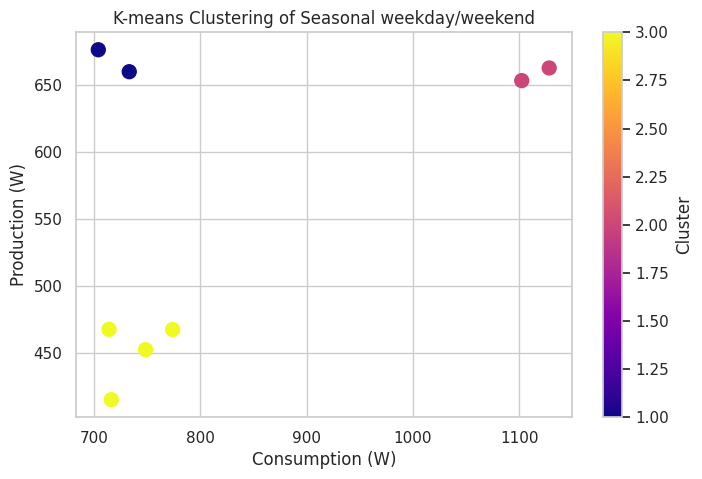

In [ ]:
# Cluster weeks & seasons
# Extract features for clustering
features = weekly_df[['Consumption', 'Production']]

# Apply K-means clustering
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(features)
cluster_labels = kmeans.labels_ +1

# Visualize the clusters
plt.figure(figsize=(8, 5))
plt.scatter(features['Consumption'], features['Production'], c=cluster_labels, cmap='plasma', s=100)
plt.xlabel('Consumption (W)')
plt.ylabel('Production (W)')
plt.title('K-means Clustering of Seasonal weekday/weekend')
plt.colorbar(label='Cluster')
plt.grid(True)  # Add grid
plt.show()

In [ ]:
len(cluster_labels)

8

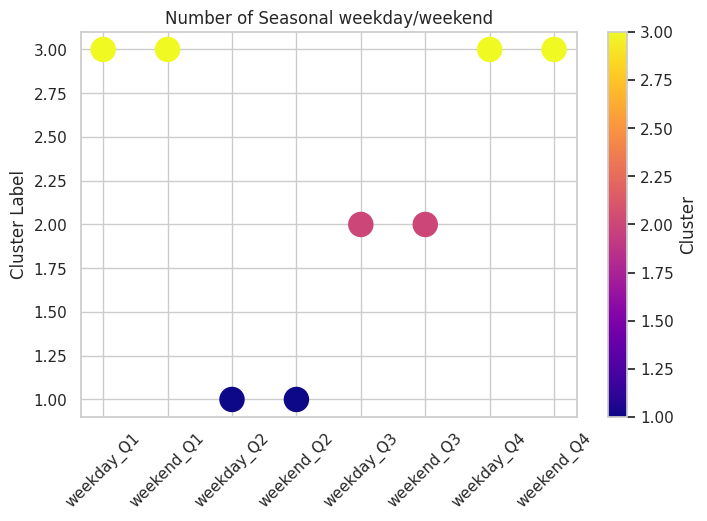

In [ ]:
# Set the figure size
plt.figure(figsize=(8, 5))

# Plot cluster labels vs months
plt.scatter(week_quarter, cluster_labels , c=cluster_labels, cmap='plasma', s=300)
plt.ylabel('Cluster Label')
plt.title('Number of Seasonal weekday/weekend')
plt.xticks(rotation=45)
plt.colorbar(label='Cluster')
plt.grid(True)  # Add grid
plt.show()

# Weather Data Concatenation. Average data
Concatenate data of Production, Consumption
with weather data. Received from:
https://toolkit.solcast.com.au/


In [ ]:
#### Upload and read the Weather csv file
weather_df = pd.read_csv("Weather_data_Cyprus_2016_30min.csv")

# Get the last row of the DataFrame
last_row = weather_df.iloc[-1]
# Append the last row to the DataFrame
weather_df = pd.concat([weather_df, pd.DataFrame([last_row])], ignore_index=True)

weather_df.info()
weather_df.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17569 entries, 0 to 17568
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            17569 non-null  int64  
 1   dhi                 17569 non-null  int64  
 2   ghi                 17569 non-null  int64  
 3   relative_humidity   17569 non-null  float64
 4   wind_direction_10m  17569 non-null  int64  
 5   wind_speed_10m      17569 non-null  float64
 6   period_end          17569 non-null  object 
 7   period              17569 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 1.1+ MB


air_temp  dhi  ghi  relative_humidity  wind_direction_10m  \
17559         6    0    0               73.2                 250   
17560         6    0    0               73.7                 252   
17561         6    0    0               74.3                 256   
17562         6    0    0               75.1                 262   
17563         5    0    0               76.0                 270   
17564         5    0    0               76.9                 281   
17565         4    0    0               77.0                 288   
17566         4    0    0               76.2                 291   
17567         4    0    0               76.3                 292   
17568         4    0    0               76.3                 292   

       wind_speed_10m            period_end period  
17559             2.0  2016-12-31T19:30:00Z  PT30M  
17560             2.0  2016-12-31T20:00:00Z  PT30M  
17561             2.0  2016-12-31T20:30:00Z  PT30M  
17562             2.1  2016-12-31T21:00:00Z  PT30M  
17563             2.1  2016-12-31T21:30:00Z  PT30M  
17564             2.1  2016-12-31T22:00:00Z  PT30M  
17565             2.1  2016-12-31T22:30:00Z  PT30M  
17566             2.1  2016-12-31T23:00:00Z  PT30M  
17567             2.2  2016-12-31T23:30:00Z  PT30M  
17568             2.2  2016-12-31T23:30:00Z  PT30M

Take the Average data of all houses

In [ ]:
remove_col = ['day_type']
# Use the `drop()` method to remove the columns
combined_df = combined_df.drop(columns=remove_col)

# Take the average of each timestamp
yearday_df = combined_df.groupby(['Timestamp']).mean().reset_index()
yearday_df.info()
yearday_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    17564 non-null  datetime64[ns]
 1   NM_meter     17564 non-null  float64       
 2   Import       17564 non-null  float64       
 3   Export       17564 non-null  float64       
 4   PV_meter     17564 non-null  float64       
 5   Production   17564 non-null  float64       
 6   Consumption  17564 non-null  float64       
 7   NetLoad      17564 non-null  float64       
 8   day          17564 non-null  float64       
 9   day_of_week  17564 non-null  float64       
 10  month        17564 non-null  float64       
 11  year         17564 non-null  float64       
 12  hour_of_day  17564 non-null  float64       
 13  quarter      17564 non-null  float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.9 MB


Timestamp    NM_meter       Import  Export    PV_meter  \
0 2016-01-01 00:00:00  614.941176  1034.182794     0.0  586.632353   
1 2016-01-01 00:30:00  614.941176   892.905882     0.0  586.632353   
2 2016-01-01 01:00:00  614.941176   995.311765     0.0  586.632353   
3 2016-01-01 01:30:00  614.941176   855.753088     0.0  586.632353   
4 2016-01-01 02:00:00  614.941176   828.964706     0.0  586.632353   

   Production  Consumption      NetLoad  day  day_of_week  month    year  \
0         0.0  1034.182794  1034.182794  1.0          4.0    1.0  2016.0   
1         0.0   892.905882   892.905882  1.0          4.0    1.0  2016.0   
2         0.0   995.311765   995.311765  1.0          4.0    1.0  2016.0   
3         0.0   855.753088   855.753088  1.0          4.0    1.0  2016.0   
4         0.0   828.964706   828.964706  1.0          4.0    1.0  2016.0   

   hour_of_day  quarter  
0          0.0      1.0  
1          0.0      1.0  
2          1.0      1.0  
3          1.0      1.0  
4          2.0      1.0

In [ ]:
# Add the Weather Data in the dataset
combinedNew_df = pd.concat([weather_df, yearday_df], axis=1)
#combinedNew_df.info()
#combinedNew_df.head()

# List the columns you want to remove
#remove_cols = ['period_end', 'period', 'day', 'month','year','hour_of_day' , 'NM_meter','PV_meter']
#remove_cols = ['period_end', 'period', 'day', 'month','year','hour_of_day' , 'NM_meter','PV_meter', 'Import','Export','NetLoad']
#remove_cols = ['Timestamp','period_end', 'period', 'year' , 'NM_meter','PV_meter', 'Import','Export','NetLoad']
remove_cols = ['Timestamp','period_end', 'period', 'year' , 'NM_meter','PV_meter', 'Import','Export']
#remove_cols = ['Timestamp','period_end', 'period', 'year' , 'NM_meter','PV_meter', 'Import','Export','Production','Consumption','quarter','day']

# Use the `drop()` method to remove the columns
combinedNew_df = combinedNew_df.drop(columns=remove_cols)
combinedNew_df = combinedNew_df.dropna()
#combinedNew_df.info()
#ombinedNew_df.head(20)

In [ ]:
combinedNew_df.info()
combinedNew_df.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            17564 non-null  int64  
 1   dhi                 17564 non-null  int64  
 2   ghi                 17564 non-null  int64  
 3   relative_humidity   17564 non-null  float64
 4   wind_direction_10m  17564 non-null  int64  
 5   wind_speed_10m      17564 non-null  float64
 6   Production          17564 non-null  float64
 7   Consumption         17564 non-null  float64
 8   NetLoad             17564 non-null  float64
 9   day                 17564 non-null  float64
 10  day_of_week         17564 non-null  float64
 11  month               17564 non-null  float64
 12  hour_of_day         17564 non-null  float64
 13  quarter             17564 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 2.0 MB


air_temp  dhi  ghi  relative_humidity  wind_direction_10m  wind_speed_10m  \
0          2    0    0               81.2                  20             2.1   
1          2    0    0               81.2                  20             2.1   
2          2    0    0               81.1                  16             2.1   
3          2    0    0               81.1                  12             2.2   
4          2    0    0               81.1                   8             2.5   
5          2    0    0               80.8                   3             2.8   
6          2    0    0               80.2                 357             2.9   
7          1    0    0               79.7                 353             2.9   
8          2    0    0               79.4                 351             3.0   
9          1    0    0               78.0                 349             3.0   
10         1    0    0               75.4                 346             2.9   
11         1   22   22               72.9                 344             3.0   
12         1   56   56               70.5                 345             3.1   
13         2  111  111               66.8                 348             3.4   
14         2  138  138               62.1                 351             3.8   
15         2  182  182               57.9                 353             4.0   
16         3  236  236               54.2                 352             4.0   
17         3  273  273               51.2                 350             4.0   
18         3  285  285               49.0                 348             3.9   
19         4  300  300               46.5                 348             3.9   

    Production  Consumption      NetLoad  day  day_of_week  month  \
0     0.000000  1034.182794  1034.182794  1.0          4.0    1.0   
1     0.000000   892.905882   892.905882  1.0          4.0    1.0   
2     0.000000   995.311765   995.311765  1.0          4.0    1.0   
3     0.000000   855.753088   855.753088  1.0          4.0    1.0   
4     0.000000   828.964706   828.964706  1.0          4.0    1.0   
5     0.000000   850.352353   850.352353  1.0          4.0    1.0   
6     0.000000   737.877941   737.877941  1.0          4.0    1.0   
7     0.000000   649.641176   649.641176  1.0          4.0    1.0   
8     0.000000   571.716618   571.716618  1.0          4.0    1.0   
9     0.000000   525.216618   525.216618  1.0          4.0    1.0   
10    0.000000   569.441324   569.441324  1.0          4.0    1.0   
11    0.000000   611.975000   611.975000  1.0          4.0    1.0   
12    0.000000   599.170882   599.170882  1.0          4.0    1.0   
13    0.000000   631.398529   631.398529  1.0          4.0    1.0   
14    0.000588   574.887941   574.887353  1.0          4.0    1.0   
15    5.261912   565.793088   560.531176  1.0          4.0    1.0   
16   60.634478   668.813582   608.179104  1.0          4.0    1.0   
17  243.575152   735.305758   491.730606  1.0          4.0    1.0   
18  487.526418   840.995373   353.468955  1.0          4.0    1.0   
19  721.977910   834.250896   112.272985  1.0          4.0    1.0   

    hour_of_day  quarter  
0           0.0      1.0  
1           0.0      1.0  
2           1.0      1.0  
3           1.0      1.0  
4           2.0      1.0  
5           2.0      1.0  
6           3.0      1.0  
7           3.0      1.0  
8           4.0      1.0  
9           4.0      1.0  
10          5.0      1.0  
11          5.0      1.0  
12          6.0      1.0  
13          6.0      1.0  
14          7.0      1.0  
15          7.0      1.0  
16          8.0      1.0  
17          8.0      1.0  
18          9.0      1.0  
19          9.0      1.0

# Data Analysis & Pre-Processing



In [ ]:
'''
### Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
'''

'\n### Linear regression\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error\nfrom sklearn.metrics import accuracy_score, precision_score, roc_auc_score\n'

In [ ]:
### The dataset is for 24x2x326 half-hours in a year  (for an average household)
combinedNew_df.info()
combinedNew_df.tail(100)
combinedNew_df = combinedNew_df.dropna()

# Check if there are missing values after cleaning
missing_values = combinedNew_df[combinedNew_df.isnull().any(axis=1)]
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
Index: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            17564 non-null  int64  
 1   dhi                 17564 non-null  int64  
 2   ghi                 17564 non-null  int64  
 3   relative_humidity   17564 non-null  float64
 4   wind_direction_10m  17564 non-null  int64  
 5   wind_speed_10m      17564 non-null  float64
 6   Production          17564 non-null  float64
 7   Consumption         17564 non-null  float64
 8   NetLoad             17564 non-null  float64
 9   day                 17564 non-null  float64
 10  day_of_week         17564 non-null  float64
 11  month               17564 non-null  float64
 12  hour_of_day         17564 non-null  float64
 13  quarter             17564 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 2.0 MB
Empty DataFrame
Columns: [air_temp, dhi, ghi, relative_humidi

Do Correlation analysis with weather parameters

In [ ]:
#import plotly.express as px
#fig = px.histogram(combinedNew_df, x='Consumption', marginal='box', color_discrete_sequence=['green', 'grey'], title='Consumption')
#fig.update_layout(bargap=0.1)
#fig.show()

[Text(0.5, 0, 'air_temp'),
 Text(1.5, 0, 'dhi'),
 Text(2.5, 0, 'ghi'),
 Text(3.5, 0, 'relative_humidity'),
 Text(4.5, 0, 'wind_direction_10m'),
 Text(5.5, 0, 'wind_speed_10m'),
 Text(6.5, 0, 'Production'),
 Text(7.5, 0, 'Consumption'),
 Text(8.5, 0, 'NetLoad'),
 Text(9.5, 0, 'day'),
 Text(10.5, 0, 'day_of_week'),
 Text(11.5, 0, 'month'),
 Text(12.5, 0, 'hour_of_day'),
 Text(13.5, 0, 'quarter')]

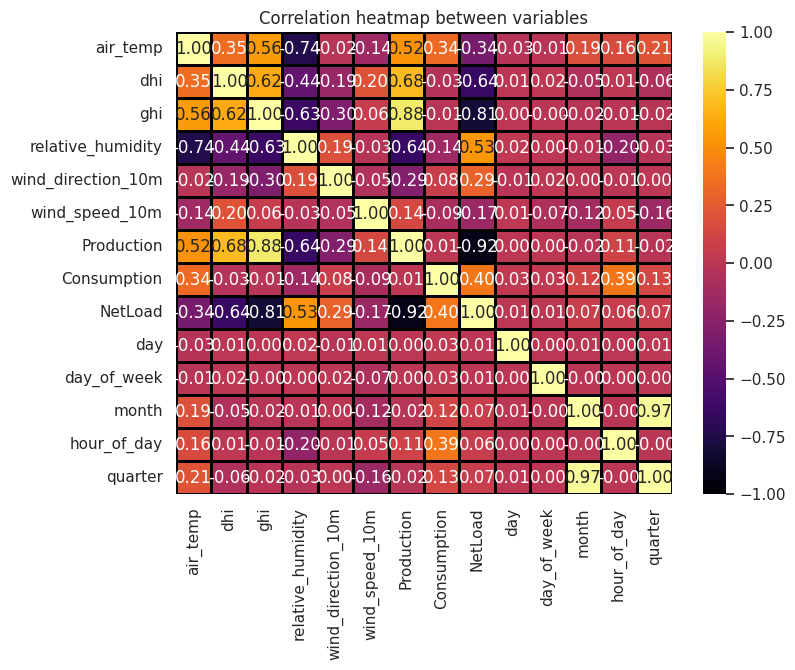

In [ ]:
import seaborn as sns

### Correlation Matrix
corr_df =combinedNew_df.corr(method="pearson")

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(corr_df, annot=True, fmt=".2f" ,vmin=-1, center = 0,cmap="inferno", linewidth=2, linecolor = "black")
heatmap.set_title("Correlation heatmap between variables")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

Feature Engineering

In [ ]:
## Do some feature engineering first
#	Feature Crossing (x1*x2, log(x1)  etc.)

# Make some feature to have. We cannot have same-day Prod, Cons
# Features here should be: Historical_Cons , historical_Prod.
# previous day forecast
# previous week foecast
# These are Lagged features and Rolling averages

# Choose output
#target_col = 'Production'
#target_col = 'Consumption'
target_col = 'NetLoad'

# Lagged features: 1,2 and 7 days before.
# Depending on the Forecast model: For lag1 --> day_ahead Forecast
#  For lag7 --> day_ahead Forecast
combinedNew_df['NL_lag1'] = combinedNew_df[target_col].shift(1*48)  # Lag by 1 days
combinedNew_df['NL_lag2'] = combinedNew_df[target_col].shift(2*48)  # Lag by 2 days
combinedNew_df['NL_lag7'] = combinedNew_df[target_col].shift(7*48)  # Lag by 7 days

# Rolling averages
combinedNew_df['NL_rolling_avg_1'] = combinedNew_df[target_col].rolling(window=48).mean()
combinedNew_df['NL_rolling_avg_7'] = combinedNew_df[target_col].rolling(window=48*7).mean()

#Handling Missing Values
combinedNew_df.bfill( inplace=True)  # Backfill
#combinedNew_df.fillna(method='ffill', inplace=True)  # Forward fill
#combinedNew_df.fillna(combinedNew_df['Consumption'].mean(), inplace=True)  # Fill with overall mean

### The dataset is for 24x2x326 half-hours in a year
combinedNew_df.info()
combinedNew_df.tail(100)

<class 'pandas.core.frame.DataFrame'>
Index: 17564 entries, 0 to 17563
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            17564 non-null  int64  
 1   dhi                 17564 non-null  int64  
 2   ghi                 17564 non-null  int64  
 3   relative_humidity   17564 non-null  float64
 4   wind_direction_10m  17564 non-null  int64  
 5   wind_speed_10m      17564 non-null  float64
 6   Production          17564 non-null  float64
 7   Consumption         17564 non-null  float64
 8   NetLoad             17564 non-null  float64
 9   day                 17564 non-null  float64
 10  day_of_week         17564 non-null  float64
 11  month               17564 non-null  float64
 12  hour_of_day         17564 non-null  float64
 13  quarter             17564 non-null  float64
 14  NL_lag1             17564 non-null  float64
 15  NL_lag2             17564 non-null  float64
 16  NL_lag7  

air_temp  dhi  ghi  relative_humidity  wind_direction_10m  \
17464         9    0    0               85.6                 197   
17465         9    0    0               86.9                 193   
17466         8    0    0               87.5                 187   
17467         8    0    0               88.0                 186   
17468         8    0    0               88.2                 187   
...         ...  ...  ...                ...                 ...   
17559         6    0    0               73.2                 250   
17560         6    0    0               73.7                 252   
17561         6    0    0               74.3                 256   
17562         6    0    0               75.1                 262   
17563         5    0    0               76.0                 270   

       wind_speed_10m  Production  Consumption      NetLoad   day  \
17464             1.9         0.0  1209.214265  1209.214265  29.0   
17465             1.9         0.0   996.892647   996.892647  29.0   
17466             2.1         0.0   995.701912   995.701912  29.0   
17467             2.0         0.0  1086.604853  1086.604853  29.0   
17468             1.7         0.0   963.446176   963.446176  30.0   
...               ...         ...          ...          ...   ...   
17559             2.0         0.0  1368.491765  1368.491765  31.0   
17560             2.0         0.0  1255.384853  1255.384853  31.0   
17561             2.0         0.0  1127.254265  1127.254265  31.0   
17562             2.1         0.0   963.106324   963.106324  31.0   
17563             2.1         0.0   993.230147   993.230147  31.0   

       day_of_week  month  hour_of_day  quarter      NL_lag1      NL_lag2  \
17464          3.0   12.0         22.0      4.0  1216.381471  1411.121912   
17465          3.0   12.0         22.0      4.0  1281.754118  1297.282206   
17466          3.0   12.0         23.0      4.0  1186.190000  1172.096324   
17467          3.0   12.0         23.0      4.0  1152.155147  1254.333676   
17468          4.0   12.0          0.0      4.0  1129.359559   973.601471   
...            ...    ...          ...      ...          ...          ...   
17559          5.0   12.0         21.0      4.0  1216.024706  1279.949559   
17560          5.0   12.0         22.0      4.0  1138.853971  1209.214265   
17561          5.0   12.0         22.0      4.0  1164.367794   996.892647   
17562          5.0   12.0         23.0      4.0  1065.313529   995.701912   
17563          5.0   12.0         23.0      4.0   962.598088  1086.604853   

           NL_lag7  NL_rolling_avg_1  NL_rolling_avg_7  
17464  1445.051471        691.124940        748.457943  
17465  1357.681765        685.190326        747.384166  
17466  1359.130294        681.221824        746.302534  
17467  1203.570000        679.856193        745.954423  
17468   902.728676        676.399664        746.135130  
...            ...               ...               ...  
17559  1447.223529        682.786030        690.160326  
17560  1355.346324        685.213757        689.862821  
17561  1407.143235        684.440558        689.029819  
17562  1329.569559        682.311241        687.939154  
17563  1120.730000        682.949409        687.559690  

[100 rows x 19 columns]

In [ ]:
#combinedNew_df.to_csv('combinedNew_df.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

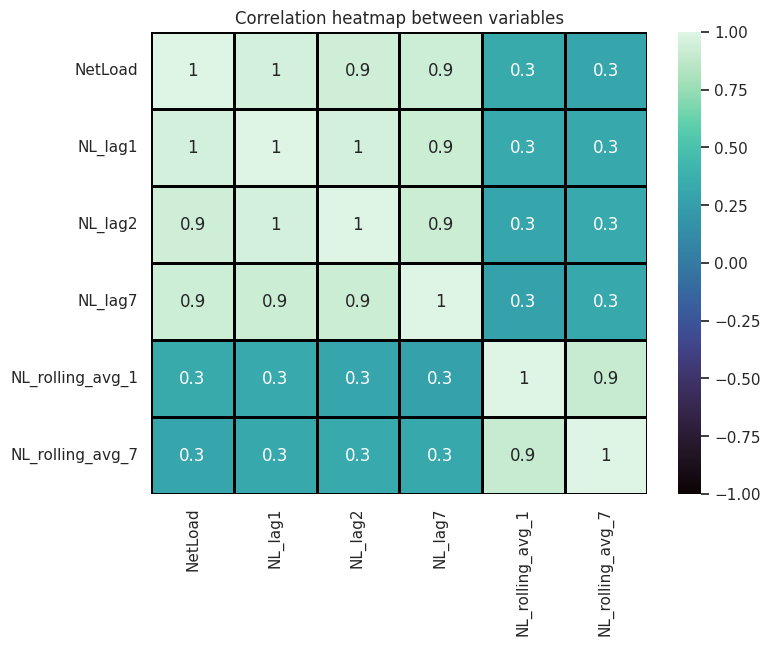

In [ ]:
### Correlation Matrix (Correlate Output with Inputs)
remove_cols2 = ['Production','Consumption','air_temp', 'dhi', 'ghi','relative_humidity','wind_direction_10m',
              'wind_speed_10m','day','day_of_week','quarter','month','hour_of_day']
history_df = combinedNew_df.drop(columns=remove_cols2)
corr_df = history_df.corr(method="pearson")

plt.figure(figsize=(8, 6))  # Set the figure size
heatmap = sns.heatmap(corr_df, annot=True, fmt=".1g" ,vmin=-1, center = 0, cmap="mako", linewidth=2, linecolor = "black")
heatmap.set_title("Correlation heatmap between variables")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
plt.show


In [ ]:
# Select the input features' columns

# Without historical data. Assume we know the weather forecast
#input_cols = ['air_temp', 'dhi', 'ghi','relative_humidity','wind_direction_10m',
#              'wind_speed_10m','day','day_of_week','month','hour_of_day']


# Training inputs for day-ahead Forecasting model
# Including Historical data. Assume we know weather forecast (for dau-ahead)
input_cols = ['air_temp', 'dhi', 'ghi','relative_humidity','wind_direction_10m',
              'wind_speed_10m', 'day','day_of_week','month','hour_of_day',
              'NL_lag1',	'NL_lag2',	'NL_lag7',	'NL_rolling_avg_1','NL_rolling_avg_7' ]

'''
# Training inputs for week-ahead Forecasting model
# Including Historical data. Assume we know weather forecast (for dau-ahead)
input_cols = ['air_temp', 'dhi', 'ghi','relative_humidity','wind_direction_10m',
              'wind_speed_10m', 'day','day_of_week','month','hour_of_day',
               'NL_lag7',	 'NL_rolling_avg_7' ]
'''
# Select the target
#output_cols =[ 'Consumption']
#output_cols =[ 'Production']
output_cols =[ 'NetLoad']

inputs = combinedNew_df[input_cols]
output = combinedNew_df[output_cols]
inputs.describe()

air_temp           dhi           ghi  relative_humidity  \
count  17564.000000  17564.000000  17564.000000       17564.000000   
mean      19.748349     66.449157    223.110852          53.801890   
std        8.539800     98.685585    306.963689          21.122011   
min       -2.000000      0.000000      0.000000           6.100000   
25%       13.000000      0.000000      0.000000          35.500000   
50%       20.000000      6.000000      6.000000          52.000000   
75%       26.000000     99.000000    423.000000          71.925000   
max       39.000000    596.000000   1053.000000          97.800000   

       wind_direction_10m  wind_speed_10m          day   day_of_week  \
count        17564.000000    17564.000000  17564.00000  17564.000000   
mean           233.769529        1.801401     15.75427      3.007515   
std             94.663781        1.107081      8.81115      1.997707   
min              0.000000        0.000000      1.00000      0.000000   
25%            197.000000        1.100000      8.00000      1.000000   
50%            267.000000        1.600000     16.00000      3.000000   
75%            301.000000        2.200000     23.00000      5.000000   
max            360.000000        8.000000     31.00000      6.000000   

              month   hour_of_day       NL_lag1       NL_lag2       NL_lag7  \
count  17564.000000  17564.000000  17564.000000  17564.000000  17564.000000   
mean       6.514461     11.501594    262.203483    263.203070    267.874523   
std        3.451318      6.922329    832.937457    833.186030    834.542315   
min        1.000000      0.000000  -1867.030147  -1867.030147  -1867.030147   
25%        4.000000      6.000000   -313.345769   -313.189738   -308.500097   
50%        7.000000     12.000000    441.460074    442.149272    444.990441   
75%       10.000000     18.000000    871.928787    876.120515    892.261581   
max       12.000000     23.000000   2050.496324   2050.496324   2050.496324   

       NL_rolling_avg_1  NL_rolling_avg_7  
count      17564.000000      17564.000000  
mean         261.171127        261.422596  
std          283.419582        264.072424  
min         -223.954889       -181.533436  
25%           22.817860         30.364094  
50%          219.596140        207.123165  
75%          496.296506        499.681530  
max          992.184786        798.842578

In [ ]:
inputs.info()
inputs.head()

<class 'pandas.core.frame.DataFrame'>
Index: 17564 entries, 0 to 17563
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            17564 non-null  int64  
 1   dhi                 17564 non-null  int64  
 2   ghi                 17564 non-null  int64  
 3   relative_humidity   17564 non-null  float64
 4   wind_direction_10m  17564 non-null  int64  
 5   wind_speed_10m      17564 non-null  float64
 6   day                 17564 non-null  float64
 7   day_of_week         17564 non-null  float64
 8   month               17564 non-null  float64
 9   hour_of_day         17564 non-null  float64
 10  NL_lag1             17564 non-null  float64
 11  NL_lag2             17564 non-null  float64
 12  NL_lag7             17564 non-null  float64
 13  NL_rolling_avg_1    17564 non-null  float64
 14  NL_rolling_avg_7    17564 non-null  float64
dtypes: float64(11), int64(4)
memory usage: 2.1 MB


air_temp  dhi  ghi  relative_humidity  wind_direction_10m  wind_speed_10m  \
0         2    0    0               81.2                  20             2.1   
1         2    0    0               81.2                  20             2.1   
2         2    0    0               81.1                  16             2.1   
3         2    0    0               81.1                  12             2.2   
4         2    0    0               81.1                   8             2.5   

   day  day_of_week  month  hour_of_day      NL_lag1      NL_lag2  \
0  1.0          4.0    1.0          0.0  1034.182794  1034.182794   
1  1.0          4.0    1.0          0.0  1034.182794  1034.182794   
2  1.0          4.0    1.0          1.0  1034.182794  1034.182794   
3  1.0          4.0    1.0          1.0  1034.182794  1034.182794   
4  1.0          4.0    1.0          2.0  1034.182794  1034.182794   

       NL_lag7  NL_rolling_avg_1  NL_rolling_avg_7  
0  1034.182794        706.046606        700.890597  
1  1034.182794        706.046606        700.890597  
2  1034.182794        706.046606        700.890597  
3  1034.182794        706.046606        700.890597  
4  1034.182794        706.046606        700.890597

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on the training data
scaler.fit(inputs)
# Transform the training data
inputs_scaled = scaler.transform(inputs)
# Convert the scaled arrays back to DataFrame for easier handling
inputs_scaled = pd.DataFrame(inputs_scaled, columns=inputs.columns)
inputs_scaled.info()
inputs_scaled.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            17564 non-null  float64
 1   dhi                 17564 non-null  float64
 2   ghi                 17564 non-null  float64
 3   relative_humidity   17564 non-null  float64
 4   wind_direction_10m  17564 non-null  float64
 5   wind_speed_10m      17564 non-null  float64
 6   day                 17564 non-null  float64
 7   day_of_week         17564 non-null  float64
 8   month               17564 non-null  float64
 9   hour_of_day         17564 non-null  float64
 10  NL_lag1             17564 non-null  float64
 11  NL_lag2             17564 non-null  float64
 12  NL_lag7             17564 non-null  float64
 13  NL_rolling_avg_1    17564 non-null  float64
 14  NL_rolling_avg_7    17564 non-null  float64
dtypes: float64(15)
memory usage: 2.0 MB


air_temp       dhi       ghi  relative_humidity  wind_direction_10m  \
0  -2.078369 -0.673361 -0.726852           1.297172           -2.258262   
1  -2.078369 -0.673361 -0.726852           1.297172           -2.258262   
2  -2.078369 -0.673361 -0.726852           1.292438           -2.300518   
3  -2.078369 -0.673361 -0.726852           1.292438           -2.342774   
4  -2.078369 -0.673361 -0.726852           1.292438           -2.385030   
5  -2.078369 -0.673361 -0.726852           1.278234           -2.437850   
6  -2.078369 -0.673361 -0.726852           1.249827            1.301807   
7  -2.195471 -0.673361 -0.726852           1.226154            1.259551   
8  -2.078369 -0.673361 -0.726852           1.211951            1.238423   
9  -2.195471 -0.673361 -0.726852           1.145667            1.217295   
10 -2.195471 -0.673361 -0.726852           1.022570            1.185603   
11 -2.195471 -0.450425 -0.655180           0.904206            1.164475   
12 -2.195471 -0.105886 -0.544415           0.790577            1.175039   
13 -2.078369  0.451455 -0.365236           0.615400            1.206731   
14 -2.078369  0.725059 -0.277275           0.392877            1.238423   
15 -2.078369  1.170932 -0.133931           0.194026            1.259551   
16 -1.961267  1.718140  0.041990           0.018849            1.248987   
17 -1.961267  2.093079  0.162529          -0.123187            1.227859   
18 -1.961267  2.214681  0.201623          -0.227347            1.206731   
19 -1.844165  2.366683  0.250490          -0.345710            1.206731   

    wind_speed_10m       day  day_of_week    month  hour_of_day   NL_lag1  \
0         0.269725 -1.674548     0.496826 -1.59783    -1.661568  0.926842   
1         0.269725 -1.674548     0.496826 -1.59783    -1.661568  0.926842   
2         0.269725 -1.674548     0.496826 -1.59783    -1.517104  0.926842   
3         0.360056 -1.674548     0.496826 -1.59783    -1.517104  0.926842   
4         0.631046 -1.674548     0.496826 -1.59783    -1.372640  0.926842   
5         0.902037 -1.674548     0.496826 -1.59783    -1.372640  0.926842   
6         0.992367 -1.674548     0.496826 -1.59783    -1.228176  0.926842   
7         0.992367 -1.674548     0.496826 -1.59783    -1.228176  0.926842   
8         1.082697 -1.674548     0.496826 -1.59783    -1.083712  0.926842   
9         1.082697 -1.674548     0.496826 -1.59783    -1.083712  0.926842   
10        0.992367 -1.674548     0.496826 -1.59783    -0.939247  0.926842   
11        1.082697 -1.674548     0.496826 -1.59783    -0.939247  0.926842   
12        1.173028 -1.674548     0.496826 -1.59783    -0.794783  0.926842   
13        1.444018 -1.674548     0.496826 -1.59783    -0.794783  0.926842   
14        1.805339 -1.674548     0.496826 -1.59783    -0.650319  0.926842   
15        1.985999 -1.674548     0.496826 -1.59783    -0.650319  0.926842   
16        1.985999 -1.674548     0.496826 -1.59783    -0.505855  0.926842   
17        1.985999 -1.674548     0.496826 -1.59783    -0.505855  0.926842   
18        1.895669 -1.674548     0.496826 -1.59783    -0.361391  0.926842   
19        1.895669 -1.674548     0.496826 -1.59783    -0.361391  0.926842   

     NL_lag2   NL_lag7  NL_rolling_avg_1  NL_rolling_avg_7  
0   0.925366  0.918264          1.569716          1.664242  
1   0.925366  0.918264          1.569716          1.664242  
2   0.925366  0.918264          1.569716          1.664242  
3   0.925366  0.918264          1.569716          1.664242  
4   0.925366  0.918264          1.569716          1.664242  
5   0.925366  0.918264          1.569716          1.664242  
6   0.925366  0.918264          1.569716          1.664242  
7   0.925366  0.918264          1.569716          1.664242  
8   0.925366  0.918264          1.569716          1.664242  
9   0.925366  0.918264          1.569716          1.664242  
10  0.925366  0.918264          1.569716          1.664242  
11  0.925366  0.918264          1.569716          1.664242  
12  0.925366  0.9

In [ ]:
output.info()
output.head()

<class 'pandas.core.frame.DataFrame'>
Index: 17564 entries, 0 to 17563
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   NetLoad  17564 non-null  float64
dtypes: float64(1)
memory usage: 274.4 KB


NetLoad
0  1034.182794
1   892.905882
2   995.311765
3   855.753088
4   828.964706

Prepare Test- Train Set

In [ ]:
# Assuming X contains the independent variables and y contains the dependent variable
# Split the data into training and testing sets

# Random Split
#X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(inputs_scaled, output, test_size=0.2, random_state=42)

# Lets put the test as sequential. try to predict the last 2 months
# Define the split point
split_point = int(len(inputs_scaled) * 0.8)

# Sequentially split the datasets
X_train, X_test = inputs_scaled[:split_point], inputs_scaled[split_point:]
y_train, y_test = output[:split_point], output[split_point:]



In [ ]:
X_test.info()
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513 entries, 14051 to 17563
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            3513 non-null   float64
 1   dhi                 3513 non-null   float64
 2   ghi                 3513 non-null   float64
 3   relative_humidity   3513 non-null   float64
 4   wind_direction_10m  3513 non-null   float64
 5   wind_speed_10m      3513 non-null   float64
 6   day                 3513 non-null   float64
 7   day_of_week         3513 non-null   float64
 8   month               3513 non-null   float64
 9   hour_of_day         3513 non-null   float64
 10  NL_lag1             3513 non-null   float64
 11  NL_lag2             3513 non-null   float64
 12  NL_lag7             3513 non-null   float64
 13  NL_rolling_avg_1    3513 non-null   float64
 14  NL_rolling_avg_7    3513 non-null   float64
dtypes: float64(15)
memory usage: 411.8 KB


air_temp       dhi       ghi  relative_humidity  wind_direction_10m  \
14051  0.146571 -0.673361 -0.726852           0.643807           -0.282793   
14052  0.029469 -0.673361 -0.726852           0.662745           -0.282793   
14053  0.029469 -0.673361 -0.726852           0.634338           -0.103205   
14054  0.029469 -0.673361 -0.726852           0.563320            0.097511   
14055  0.029469 -0.673361 -0.726852           0.624869            0.192587   

       wind_speed_10m       day  day_of_week     month  hour_of_day   NL_lag1  \
14051       -1.446549  0.368377     -0.50435  1.009944     1.083251  0.845809   
14052       -1.446549  0.368377     -0.50435  1.009944     1.227715  0.908652   
14053       -1.356218  0.368377     -0.50435  1.009944     1.227715  0.852156   
14054       -1.265888  0.368377     -0.50435  1.009944     1.372179  0.828088   
14055       -1.085228  0.368377     -0.50435  1.009944     1.372179  0.666156   

        NL_lag2   NL_lag7  NL_rolling_avg_1  NL_rolling_avg_7  
14051  0.774176  0.726743         -0.727340         -0.776496  
14052  0.779997  0.645909         -0.734474         -0.775199  
14053  0.757142  0.730290         -0.736299         -0.774412  
14054  0.764402  0.812958         -0.736395         -0.774363  
14055  0.765961  0.752109         -0.725634         -0.773598

In [ ]:
#np.max(y_test) - np.min(y_test)
#np.max(y_train)
#np.max(y_train) - np.min(y_train)


Plots

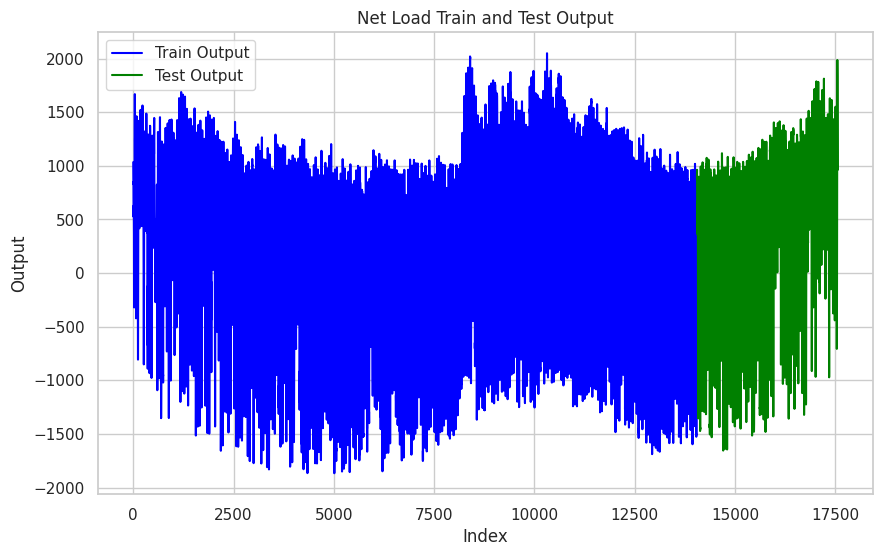

In [ ]:
### Visualizations of Data: Plot the training and test output
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Train Output', color='blue')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test Output', color='green')
plt.xlabel('Index')
plt.ylabel('Output')
plt.title('Net Load Train and Test Output')
plt.legend()
plt.show()

week number: 12


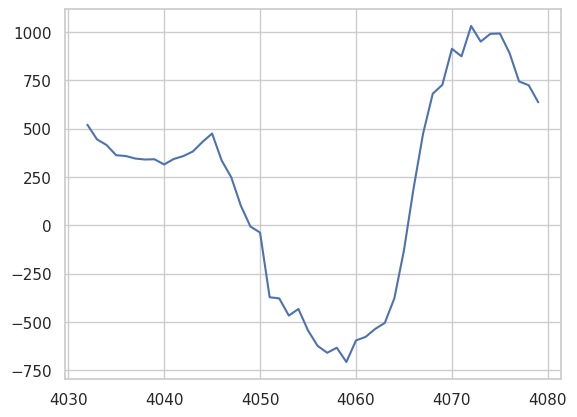

In [ ]:
#Plot a random week
import random
random_number = random.randint(1, 52)
print("week number:",random_number)

week_nr = random_number
#plt.plot(yearday_df['Consumption'].iloc[48*7*week_nr:48*7*(week_nr+1)])
#plt.plot(yearday_df['NetLoad'].iloc[48*7*week_nr:48*7*(week_nr+1)])
plt.plot(yearday_df['NetLoad'].iloc[48*7*week_nr:48*7*week_nr+48])

In [ ]:
# Autocorrelation Function (ACF) plot
#plt.figure(figsize=(12, 6))
#plot_acf(yearday_df['NetLoad'], lags=100, ax=plt.gca())
#plot_acf(cons_data_log_ma_removed_diff, lags=50, ax=plt.gca())
#plt.title('Autocorrelation Function (ACF)')
#plt.xlabel('Lag (30 min intervals)')
#plt.ylabel('Autocorrelation')
#plt.show()

In [ ]:
### Determine window
#window = 24*2*7  # window = 7*24*2

## Test stationarity
#test_stationarity(yearday_df['NetLoad'], window )

#Machine Learning models to predict Consumption
* ML: Linear Regression
* Random Forest, XGBoost


In [ ]:
import random
import matplotlib.pyplot as plt

### Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score


In [ ]:
#%%writefile /content/drive/MyDrive/Housing_data/my_functions.py

# First Define some evaluation functions
##### define som method to Evaluate the model

def evaluate(model, y_test, y_pred):

    y_test = y_test.values.flatten()  # Convert y_test to a 1D array

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print("MSE:", round(mse,2) )
    # Calculate mean Root squared error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE:", round(rmse,2) )
    # Calculate mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE:", round(mae,2) )
    # Calculate Mean absolute percentage error
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print("MAPE:", round(mape,2) , "%")

    # estimate CV RMSE. This needs to be small
    #cvrmse = rmse / y_test.mean()
    cvrmse = rmse / np.mean(y_test)
    print("CV-RMSE:", round(cvrmse * 100, 2), "%")

    # Calculate range of observed values
    y_range = np.max(y_test) - np.min(y_test)   # only Y_maximum
    #y_range = np.max(y_test)    # only Y_maximum
    # Calculate NRMSE
    nrmse = rmse / y_range
    print("nRMSE:", round(nrmse * 100, 2) , "%")

    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)
    print("R2 score:", round(r2,3) )

    # y_pred and y_actual are predicted and actual values respectively
    #fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 0), constrained_layout=True)
    plt.figure(figsize=(5, 3))
    #plt.scatter(y_test, y_pred, color='red', alpha=1.0, s=20)
    plt.scatter(y_test, y_pred, color=random_color(),s=20)

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
    plt.xlabel('Actual', fontsize=16)
    plt.ylabel('Predicted', fontsize=16)
    #plt.title('Actual vs. Predicted')
    return nrmse

# Generate a random color for plots
def random_color():
    return "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])

In [ ]:
#%%writefile -a my_functions.py
def plot_importances(coefficients):
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    })
    feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

    plt.figure(figsize=(6, 4))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
    plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

def persistence_model(y_train, y_test):
    """
    Applies the persistence model on the test set, predicting each value to be the same as the last observed.
    Parameters:
        y_train (pd.Series or pd.DataFrame): The training output dataset containing historical net load data.
        y_test (pd.Series or pd.DataFrame): The testing output dataset where predictions will be applied.
    Returns:
        pd.Series: Predicted values for the test set based on persistence model.
    """
    # Use the last value of the training set as the first prediction in the test set,
    # then shift the rest of the test set for subsequent predictions.
    predictions = y_test.shift(1*48)  # Lag by 1 days
    #predictions = y_test.shift(7*48)  # Lag by 1 days

    #Handling Missing Values
    predictions.bfill( inplace=True)  # Backfill
    #predictions.fillna(method='ffill', inplace=True)  # Forward fill
    #predictions.fillna(predictions.mean(), inplace=True)  # Fill with overall mean
    return predictions

In [ ]:
#last_train_value = y_train.iloc[-1]
#predictions = pd.concat([pd.Series(last_train_value), y_test[:-1]], ignore_index=True)
#preds2 = predictions.drop(columns=0)

#preds2.iloc[0] = preds2.iloc[1]
predictions = y_test.shift(1*48)  # Lag by 1 days
#predictions = y_test.shift(7*48)  # Lag by 7 days

#Handling Missing Values
predictions.bfill( inplace=True)  # Backfill
#predictions.fillna(method='ffill', inplace=True)  # Forward fill
#predictions.fillna(predictions.mean(), inplace=True)  # Fill with overall mean
predictions

NetLoad
14051   877.078382
14052   877.078382
14053   877.078382
14054   877.078382
14055   877.078382
...            ...
17559  1216.024706
17560  1138.853971
17561  1164.367794
17562  1065.313529
17563   962.598088

[3513 rows x 1 columns]

In [ ]:
y_test.head()

NetLoad
14051  877.078382
14052  921.983824
14053  947.140735
14054  950.627647
14055  963.440588

MSE: 103166.5
RMSE: 321.2
MAE: 176.57
MAPE: 81.64 %
CV-RMSE: 90.46 %
nRMSE: 8.82 %
R2 score: 0.798


Text(0.5, 1.0, 'Persistence model')

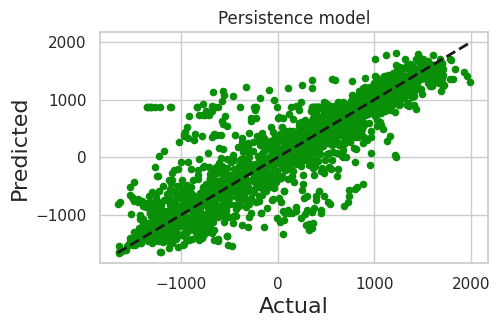

In [ ]:
#####  Apply the Persistence model
y_pred = persistence_model(y_train, y_test)

# Print first few predictions to check
#y_pred

evaluate(persistence_model, y_test, y_pred)
plt.title('Persistence model')


MSE: 49250.14
RMSE: 221.92
MAE: 148.16
MAPE: 52.15 %
CV-RMSE: 62.5 %
nRMSE: 6.09 %
R2 score: 0.904


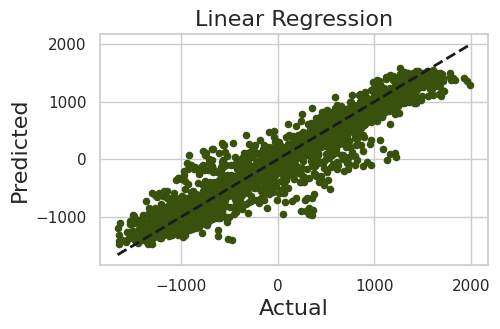

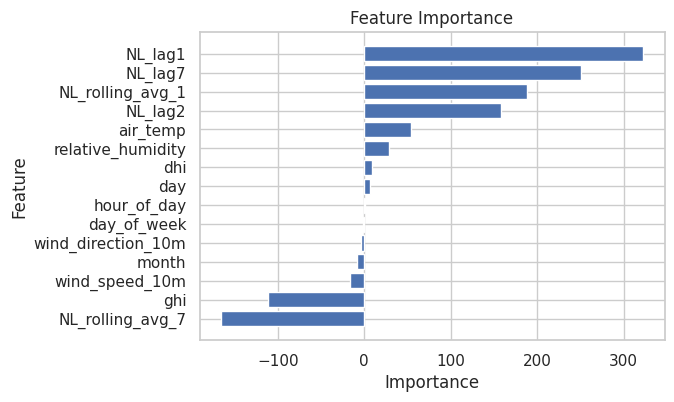

In [ ]:
####  Linear Regression
# Instantiate the linear regression model
model1 = LinearRegression()
# Fit the model to the training data
model1.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = model1.predict(X_test)

evaluate(model1, y_test, y_pred)
plt.title('Linear Regression', fontsize=16)

# Plot Feature Importances
#coefficients = model1.feature_importances_
coefficients = model1.coef_.flatten()
plot_importances(coefficients)

MSE: 49243.04
RMSE: 221.91
MAE: 148.14
nRMSE: 6.09 %
CV-RMSE: 62.5 %
R2 score: 0.904


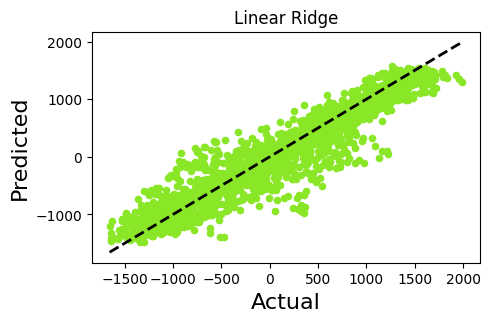

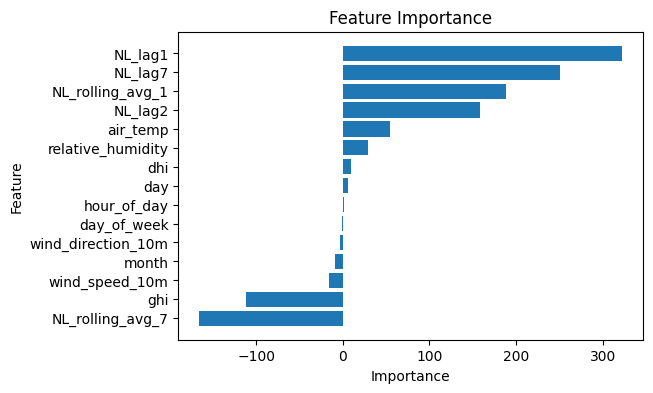

In [ ]:
# Linear Regression (Ridge model)
from sklearn.linear_model import Ridge
model2 = Ridge(random_state=42, alpha=0.9)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

evaluate(model2, y_test, y_pred)
plt.title('Linear Ridge')

coefficients = model2.coef_.flatten()
plot_importances(coefficients)

MSE: 39852.3
RMSE: 199.63
MAE: 130.46
MAPE: 59.38 %
CV-RMSE: 56.22 %
nRMSE: 5.48 %
R2 score: 0.922


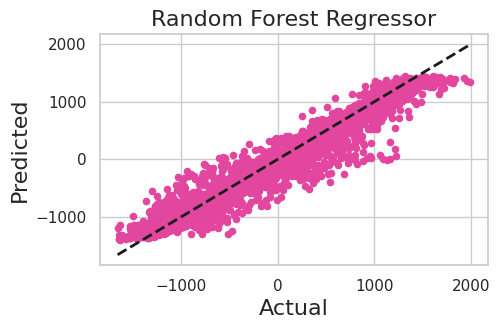

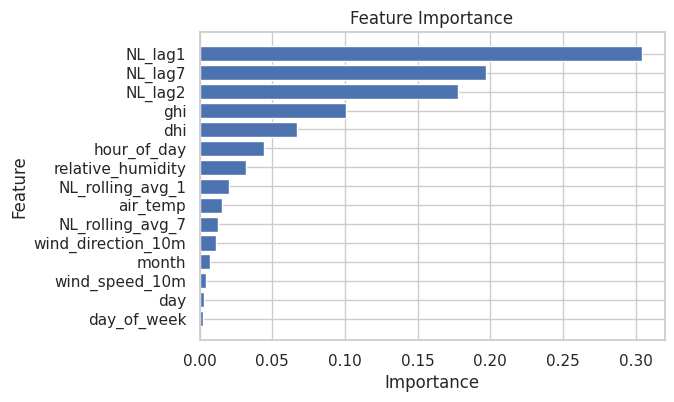

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#model3 = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=20, n_estimators =300)
model3 = RandomForestRegressor(max_depth=44, max_features='sqrt', min_samples_split=5,
                      n_estimators=149, n_jobs=-1, random_state=42);  ### Optimized

model3.fit(X_train, y_train.values.ravel())
y_pred = model3.predict(X_test)

evaluate(model3, y_test, y_pred)
plt.title('Random Forest Regressor', fontsize=16)

coefficients = model3.feature_importances_
plot_importances(coefficients)


In [ ]:
#### Hyperparameter Tuning using Random Search optimization
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt']
}

random_search = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=42, n_jobs=-1),
                                   param_distributions = param_distributions,
                                   n_iter = 100, # Number of parameter settings sampled
                                   cv = 3,
                                   verbose = 2,
                                   random_state = 42,
                                   scoring = 'neg_mean_squared_error',
                                   n_jobs = -1)

random_search.fit(X_train, y_train.values.ravel())
best_model = random_search.best_estimator_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
best_model

RandomForestRegressor(max_depth=44, max_features='sqrt', min_samples_split=5,
                      n_estimators=149, n_jobs=-1, random_state=42)

MSE: 39852.3
RMSE: 199.63
MAE: 130.46
nRMSE: 5.48 %
CV-RMSE: 56.22 %
R2 score: 0.922


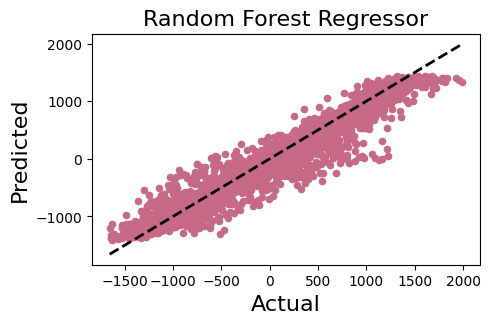

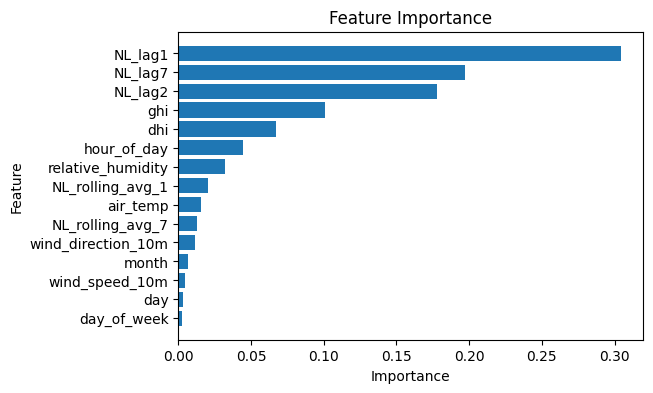

In [ ]:
#### implement best model
y_pred = best_model.predict(X_test)
evaluate(best_model, y_test, y_pred)

plt.title('Random Forest Regressor', fontsize=16)
coefficients = best_model.feature_importances_
plot_importances(coefficients)


In [ ]:
##  Cross-validation of model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier  # Example classifier
#from sklearn.datasets import load_iris

kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
scores = cross_val_score(model3, X_test, y_test, cv=kfold)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d

Accuracy: 0.96 (+/- 0.01)


[0]	validation_0-rmse:838.17901	validation_1-rmse:707.97433
[1]	validation_0-rmse:818.18124	validation_1-rmse:692.08046
[2]	validation_0-rmse:798.58009	validation_1-rmse:676.13246
[3]	validation_0-rmse:779.50906	validation_1-rmse:660.68076
[4]	validation_0-rmse:760.97613	validation_1-rmse:646.18400
[5]	validation_0-rmse:743.09299	validation_1-rmse:631.40060
[6]	validation_0-rmse:725.73437	validation_1-rmse:617.32085
[7]	validation_0-rmse:708.55960	validation_1-rmse:603.58173
[8]	validation_0-rmse:692.05055	validation_1-rmse:590.41129
[9]	validation_0-rmse:675.81919	validation_1-rmse:577.30132
[10]	validation_0-rmse:660.03776	validation_1-rmse:564.94599
[11]	validation_0-rmse:644.62815	validation_1-rmse:552.37406
[12]	validation_0-rmse:629.65821	validation_1-rmse:540.76762
[13]	validation_0-rmse:615.08339	validation_1-rmse:529.29158
[14]	validation_0-rmse:600.87600	validation_1-rmse:517.98353
[15]	validation_0-rmse:587.05377	validation_1-rmse:507.41117
[16]	validation_0-rmse:573.63461	v

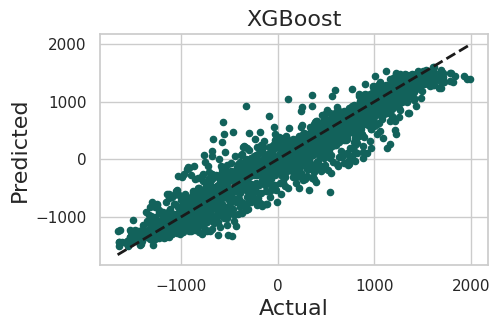

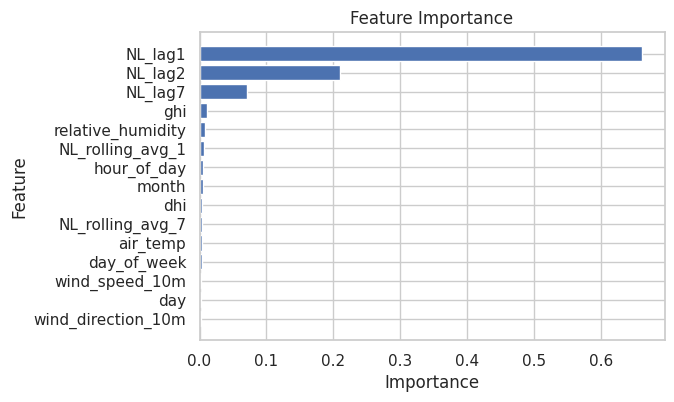

In [114]:
from xgboost import XGBRegressor
'''
#model4 = XGBRegressor(max_depth=15, objective = 'reg:squarederror', n_estimators = 200, random_state=42, n_jobs=-1)
model4 = XGBRegressor(max_depth=15,
                      learning_rate=0.05,  # Lowered learning rate
                      n_estimators=500,  # Increased number of trees
                      subsample=0.8,  # Use 80% of data to prevent overfitting
                      colsample_bytree=0.8,  # Use 80% of features
                      reg_lambda=1.0,  # L2 regularization
                      reg_alpha=0.01,  # L1 regularization, very mild
                      objective='reg:squarederror',
                      random_state=42,
                      n_jobs=-1,
                      early_stopping_rounds=100 )
'''
#### Optimized model  #####
model4 = XGBRegressor(colsample_bytree=0.80,
             early_stopping_rounds=100, enable_categorical=False,
             learning_rate=0.0254, n_estimators=323, n_jobs=-1, random_state=42, )

model4.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)], verbose=True)
y_pred = model4.predict(X_test)

evaluate(model4, y_test, y_pred)
plt.title('XGBoost', fontsize=16)

coefficients = model4.feature_importances_
plot_importances(coefficients)

In [ ]:
#### Hyperparameter Tuning using Random Search optimization
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

param_distributions = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 600),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_lambda': uniform(0.5, 1.5),
    'reg_alpha': uniform(0, 0.5)
}

xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(estimator=xgb_regressor,
                                   param_distributions=param_distributions,
                                   n_iter=50,  # Number of parameter settings sampled
                                   scoring='neg_mean_squared_error',
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# The early_stopping_rounds parameter should be passed to the fit method of random_search
random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[0]	validation_0-rmse:707.43252
[1]	validation_0-rmse:691.53664
[2]	validation_0-rmse:675.67349
[3]	validation_0-rmse:660.42965
[4]	validation_0-rmse:645.72017
[5]	validation_0-rmse:630.93375
[6]	validation_0-rmse:616.86266
[7]	validation_0-rmse:602.85252
[8]	validation_0-rmse:589.48397
[9]	validation_0-rmse:576.32155
[10]	validation_0-rmse:564.13732
[11]	validation_0-rmse:551.57927
[12]	validation_0-rmse:540.10309
[13]	validation_0-rmse:528.47627
[14]	validation_0-rmse:517.22146
[15]	validation_0-rmse:506.73595
[16]	validation_0-rmse:496.34377
[17]	validation_0-rmse:486.28162
[18]	validation_0-rmse:476.57679
[19]	validation_0-rmse:466.74131
[20]	validation_0-rmse:457.56468
[21]	validation_0-rmse:448.44571
[22]	validation_0-rmse:439.79910
[23]	validation_0-rmse:430.90947
[24]	validation_0-rmse:422.52439
[25]	validation_0-rmse:414.58469
[26]	validation_0-rmse:406.90272
[27]	validation_0-rmse:399.29724
[28]	validation_0-rmse:3

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a558da33b20>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a558c7b9cc0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a558c7b9600>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a558bb837f0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
best_model4 = random_search.best_estimator_
best_model4


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8010716092915446, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.025443625374996805, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=323, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

MSE: 37998.67
RMSE: 194.93
MAE: 127.38
nRMSE: 5.35 %
CV-RMSE: 54.9 %
R2 score: 0.926


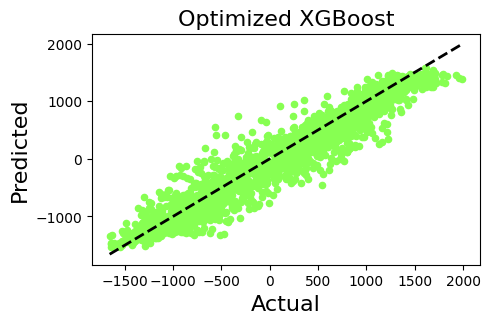

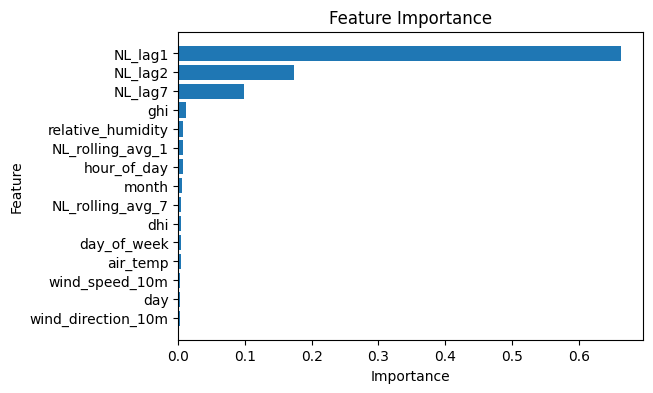

In [ ]:
#best_model4 = random_search.best_estimator_

y_pred = best_model.predict(X_test)
evaluate(best_model, y_test, y_pred)
plt.title('Optimized XGBoost', fontsize=16)

coefficients = best_model.feature_importances_
plot_importances(coefficients)


# NN models
* MLP Regressor?
* LSTM networks?

MSE: 40537.26
RMSE: 201.34
MAE: 137.01
MAPE: 65.36 %
CV-RMSE: 56.71 %
nRMSE: 5.53 %
R2 score: 0.921


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



Text(0.5, 1.0, 'MLP Regressor')

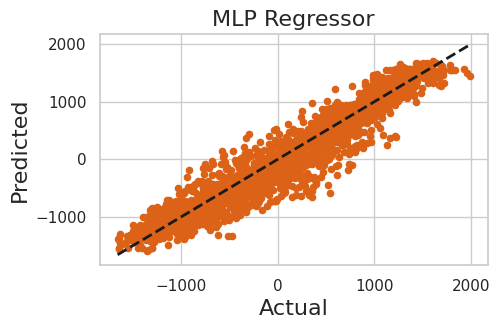

In [ ]:
from sklearn.neural_network import MLPRegressor
# Create the MLPRegressor model
# Adjust the parameters according to your specific requirements
'''
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                              alpha=0.0001, batch_size='auto', learning_rate='constant',
                              learning_rate_init=0.001, max_iter=200, shuffle=True,
                              random_state=42, tol=0.0001, verbose=False,
                              warm_start=False, early_stopping=False,
                              validation_fraction=0.1, n_iter_no_change=10,
                              max_fun=15000)
'''
## Optimized parameters
mlp_regressor = MLPRegressor(alpha=0.0002, batch_size=148,
             hidden_layer_sizes=(50,), learning_rate_init=0.00105,
             max_iter=500, random_state=42, tol=0.00065)

# Fit the model to the training data
mlp_regressor.fit(X_train, y_train.values.ravel())
# Predict on the test data
y_pred = mlp_regressor.predict(X_test)

evaluate(mlp_regressor, y_test, y_pred)
plt.title('MLP Regressor', fontsize=16)


In [ ]:
### Plot importances using permutation
def plot_importances_nn(model):
    from sklearn.inspection import permutation_importance
    # Perform permutation importance
    results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    # Get importance data
    importance = results.importances_mean

    # Optional: Bind the importance data to feature names and sort them
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df.sort_values(by="Importance", ascending=False, inplace=True)

    # Plotting feature importance
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 4))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance Using Permutation')
    plt.gca().invert_yaxis()
    plt.show()



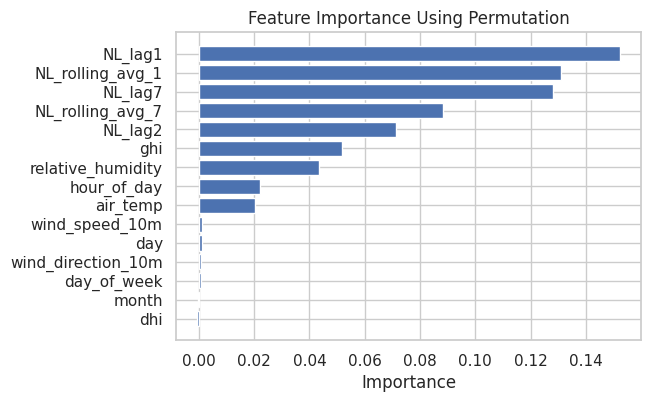

In [ ]:
plot_importances_nn(mlp_regressor)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 753, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/l

MSE: 44892.79
RMSE: 211.88
MAE: 139.95
nRMSE: 5.82 %
CV-RMSE: 59.67 %
R2 score: 0.912


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (227) reached and the optimization hasn't converged yet.



Text(0.5, 1.0, 'Optimized MLP Regressor')

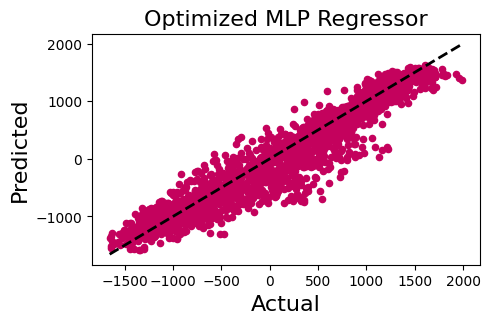

In [ ]:
### Hyperparameter Tuning using Random Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint, uniform

# Define hyperparameter distributions
param_distributions = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': uniform(0.0001, 0.01),  # Regularization parameter
    'batch_size': randint(50, 200),
    'learning_rate_init': uniform(0.001, 0.01),
    'max_iter': randint(100, 300),
    'tol': uniform(0.0001, 0.001)
}

# Initialize MLPRegressor
mlp_regressor = MLPRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=mlp_regressor,
                                   param_distributions=param_distributions,
                                   n_iter=50,  # Number of parameter settings sampled
                                   scoring='neg_mean_squared_error',
                                   cv=3,  # 3-fold cross-validation
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Fit RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Retrieve the best model
best_mlp = random_search.best_estimator_

# Predict and evaluate
y_pred = best_mlp.predict(X_test)
evaluate(best_mlp, y_test, y_pred)
plt.title('Optimized MLP Regressor', fontsize=16)



In [ ]:
best_mlp = random_search.best_estimator_
best_mlp

MLPRegressor(alpha=0.00019197051616629647, batch_size=148,
             hidden_layer_sizes=(50,), learning_rate_init=0.0010506158384621868,
             max_iter=227, random_state=42, tol=0.0006487337893665862)

MSE: 51635.82
RMSE: 227.24
MAE: 156.71
MAPE: 243.62 %
CV-RMSE: 64.0 %
nRMSE: 6.24 %
R2 score: 0.899


Text(0.5, 1.0, 'KNN Regressor')

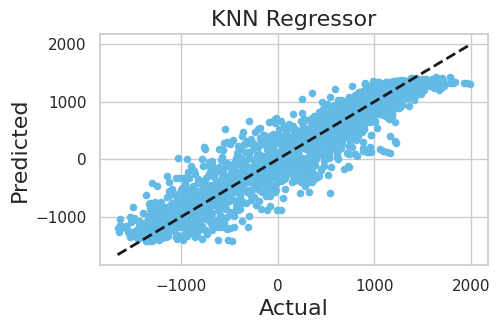

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize the KNeighborsRegressor
#knn_regressor = KNeighborsRegressor(n_neighbors=20) # tune 'n_neighbors'
knn_regressor =KNeighborsRegressor(metric='manhattan', n_neighbors=27, p=1, weights='distance')

# TFit the model to the training data
knn_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = knn_regressor.predict(X_test)
evaluate(knn_regressor, y_test, y_pred)
plt.title('KNN Regressor', fontsize=16)


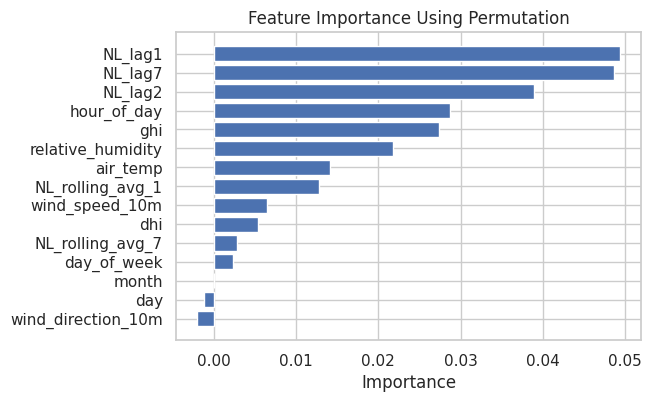

In [ ]:
plot_importances_nn(knn_regressor)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
MSE: 51635.82
RMSE: 227.24
MAE: 156.71
MAPE: 243.62 %
CV-RMSE: 64.0 %
nRMSE: 6.24 %
R2 score: 0.899


Text(0.5, 1.0, 'Optimized KNN Regressor')

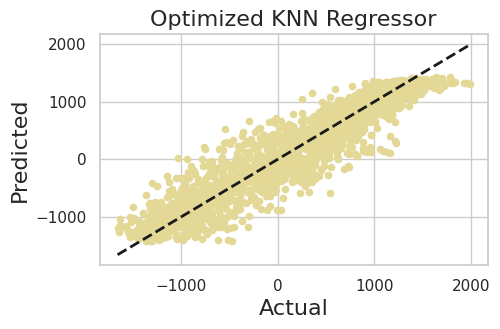

In [ ]:
# Define hyperparameter distributions
param_distributions = {
    'n_neighbors': randint(1, 30),  # Search between 1 and 30 neighbors
    'weights': ['uniform', 'distance'],  # Uniform or weighted by distance
    'p': [1, 2],  # 1 for Manhattan, 2 for Euclidean distance
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Initialize the KNeighborsRegressor
knn_regressor = KNeighborsRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=knn_regressor,
                                   param_distributions=param_distributions,
                                   n_iter=100,  # Number of parameter settings sampled
                                   scoring='neg_mean_squared_error',  # Use MSE for scoring
                                   cv=5,  # 5-fold cross-validation
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Fit RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Retrieve the best model
best_knn = random_search.best_estimator_

# Predict and evaluate
y_pred = best_knn.predict(X_test)
evaluate(best_knn, y_test, y_pred)
plt.title('Optimized KNN Regressor', fontsize=16)

In [ ]:
best_knn

KNeighborsRegressor(metric='manhattan', n_neighbors=27, p=1, weights='distance')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MSE: 48874.65
RMSE: 221.08
MAE: 150.01
MAPE: 52.43 %
CV-RMSE: 62.26 %
nRMSE: 6.07 %
R2 score: 0.904


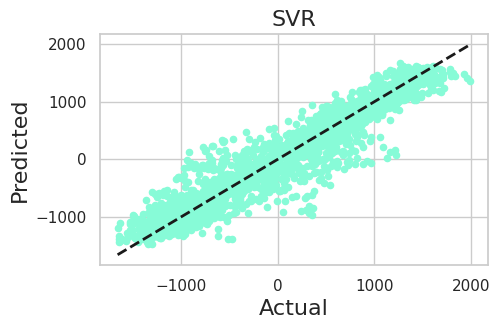

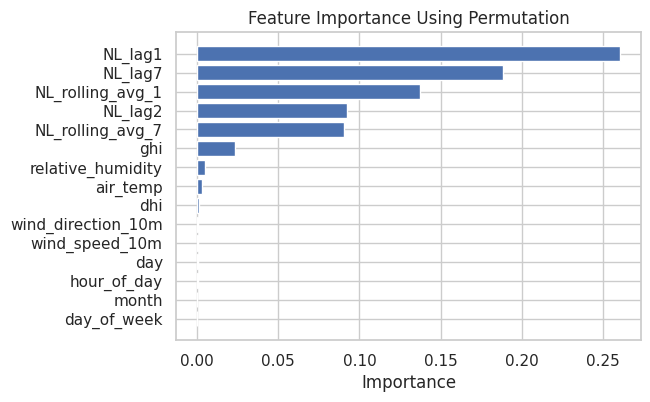

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Initialize the SVR model
model_SVR = SVR(kernel='linear', C=2000.0, epsilon=200)  # Try different kernels and parameters

# Train the model
model_SVR.fit(X_train, y_train)

# Predict on the test data
y_pred_scaled = model_SVR.predict(X_test)

# Inverse transform predictions back to original scale
#y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_pred = y_pred_scaled

# Evaluate the model
evaluate(model_SVR , y_test, y_pred)
plt.title('SVR', fontsize=16)

plot_importances_nn(model_SVR)

In [ ]:
# Tune the hyperparameters of SVM
# Initialize the SVR model
model_SVR = SVR()

param_distributions = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': loguniform(1e0, 1e3),  # wide range for regularization parameter
    'epsilon': uniform(0.01, 1.0),  # error margin
    'gamma': ['scale', 'auto'] + list(loguniform(1e-4, 1e-1).rvs(1000))  # kernel coefficient
}

random_search = RandomizedSearchCV(
    estimator=model_SVR,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings to try; adjust based on computational resource
    scoring='neg_mean_squared_error',  # Or another suitable performance metric
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Execute the random search
random_search.fit(X_train_scaled, y_train_scaled)



In [ ]:
best_svr = random_search.best_estimator_

# Predict on the test data and inverse scale if necessary
y_pred_scaled = best_svr.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Custom evaluate function
evaluate(best_svr, y_test, y_pred)
plt.title('Optimized SVR', fontsize=16)


In [ ]:
# Since SVR doesn't have a feature_importances_ attribute, you might use another approach
# such as inspecting the weights in a linear kernel or permutation importance for non-linear kernels.
if best_svr.kernel == 'linear':
    # Plotting the coefficients for linear kernel
    plt.bar(range(len(best_svr.coef_[0])), best_svr.coef_[0])
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title('Feature Importance for Linear SVR')
    plt.show()


LSTM model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
#from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
import numpy as np

#### Prepare data
# Convert pandas DataFrame to NumPy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
y_train_array = y_train.to_numpy()

# Reshape data to the format required by an LSTM ( samples,  timesteps,  features)
timesteps = 1  # You can adjust this parameter based on your data
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], timesteps, X_train_array.shape[1])
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], timesteps, X_test_array.shape[1])
# No reshaping necessary for y_train. It is typical single-output regression or classification


Epoch 1/100
352/352 [==============================] - 8s 13ms/step - loss: 729838.6875 - mse: 729838.6875 - mae: 736.1024 - val_loss: 672998.7500 - val_mse: 672998.7500 - val_mae: 730.4111
Epoch 2/100
352/352 [==============================] - 2s 6ms/step - loss: 634916.8750 - mse: 634916.8750 - mae: 673.3000 - val_loss: 583727.9375 - val_mse: 583727.9375 - val_mae: 670.2847
Epoch 3/100
352/352 [==============================] - 2s 6ms/step - loss: 557033.7500 - mse: 557033.7500 - mae: 617.9115 - val_loss: 506712.9688 - val_mse: 506712.9688 - val_mae: 614.7676
Epoch 4/100
352/352 [==============================] - 2s 6ms/step - loss: 489172.8750 - mse: 489172.8750 - mae: 566.3846 - val_loss: 439837.3750 - val_mse: 439837.3750 - val_mae: 563.9075
Epoch 5/100
352/352 [==============================] - 2s 6ms/step - loss: 430571.1875 - mse: 430571.1875 - mae: 518.1887 - val_loss: 381389.1875 - val_mse: 381389.1875 - val_mae: 515.6072
Epoch 6/100
352/352 [==============================] -

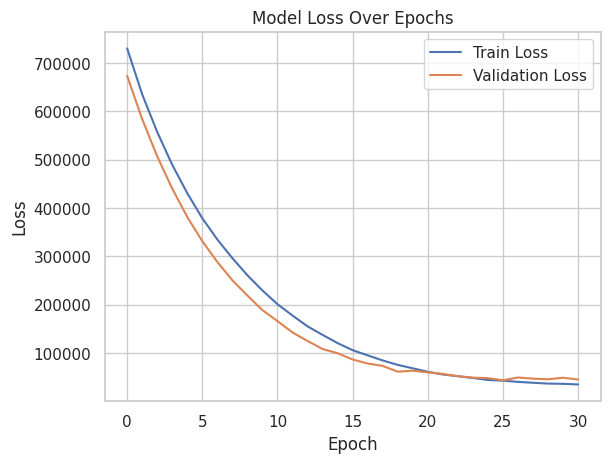

Mean Squared Error: 84903.11255027882
Mean Root Squared Error: 291.38138676016837
Mean Absolute Error: 238.15499251786912
Mean Normalized Root Squeared Error: 0.07998187740565046
R2 score: 0.8338710729402544


Text(0.5, 1.0, 'LSTM')

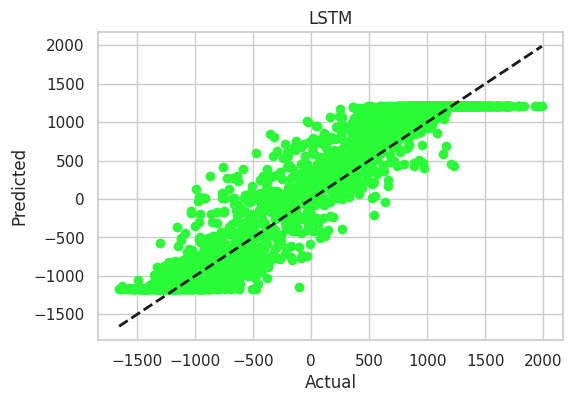

In [ ]:

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=100, activation='linear', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.2)) #dropout rate 20% -> one in five inputs will be randomly excluded from each update cycle.
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mse', 'mae'] ) #try different learing rate

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_reshaped,
                    y_train_array,
                    epochs=100,       # 150 is ok
                    batch_size=32,    # 32 is ok
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

# Predict on the test data
y_pred_3d = model.predict(X_test_reshaped)
y_pred = y_pred_3d.reshape(-1, y_pred_3d.shape[-1])

# monitor and evaluate
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model
evaluate(model, y_test, y_pred)
plt.title('LSTM', fontsize=16)


In [ ]:
loss, mse, mae = model.evaluate(X_test_reshaped, y_test, verbose=0)
print("Model loss:", loss)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Model loss: 101601.3828125
Mean Squared Error: 101601.3828125
Mean Absolute Error: 256.8777770996094


440/440 [==============================] - 1s 2ms/step


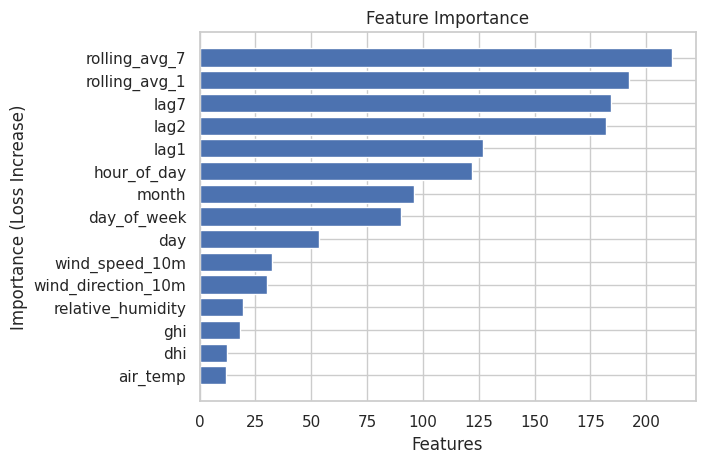

In [ ]:
# Custom Implementation for 3D Data to plot permutation importances

def score_model(model, X, y):
    import numpy as np
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred, squared=False)  # RMSE

import numpy as np

def custom_permutation_importance(model, X, y, n_repeats=10, random_state=None):
    rng = np.random.default_rng(random_state)
    baseline_score = score_model(model, X, y)
    scores = np.zeros((X.shape[2], n_repeats))  # Assuming permutation over features in the last dimension
    for feature_i in range(X.shape[2]):
        temp = X.copy()
        for n in range(n_repeats):
            # Shuffle feature across all samples and timesteps
            rng.shuffle(temp[:, :, feature_i])
            score = score_model(model, temp, y)
            scores[feature_i, n] = baseline_score - score  # Calculate loss increase due to shuffling
    return scores

# Example usage
feature_scores = custom_permutation_importance(model, X_train_reshaped, y_train, n_repeats=5, random_state=42)
feature_importances = feature_scores.mean(axis=1)

feature_importances_sorted = np.flip(np.sort( feature_importances))

# Optionally plot these importances
import matplotlib.pyplot as plt
plt.barh(X_train.columns, -feature_importances_sorted)
plt.xlabel('Features')
plt.ylabel('Importance (Loss Increase)')
plt.title('Feature Importance')
plt.show()

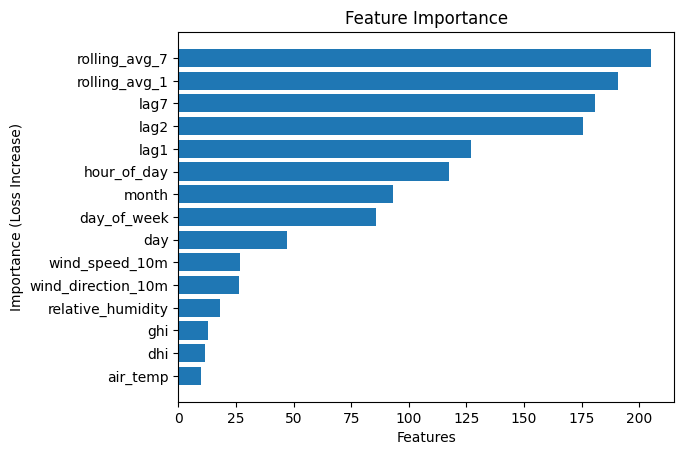

In [ ]:
# Optionally plot these importances
import matplotlib.pyplot as plt
plt.barh(X_train.columns, -feature_importances_sorted)
plt.xlabel('Features')
plt.ylabel('Importance (Loss Increase)')
plt.title('Feature Importance')
plt.show()


In [ ]:
model.summary()

In [ ]:
y_pred_3d = model.predict(X_test_reshaped)
y_pred = y_pred_3d.reshape(-1, y_pred_3d.shape[-1])

In [ ]:
# Evaluate the model
#evaluate(model)

Tune the LSTM

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=50, max_value=200, step=50),
                   activation='linear', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]),
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=20, max_value=100, step=20),
                   return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=0.0005, max_value=0.01, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mse', 'mae'])
    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # Number of variations to test
    executions_per_trial=2,  # Number of models to train per variation
    directory='my_dir',
    project_name='knn_tuning'
)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start the search
tuner.search(X_train_reshaped, y_train_array, epochs=100, batch_size=32,
             validation_split=0.2, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 19 Complete [00h 04m 25s]
val_loss: 57569.369140625

Best val_loss So Far: 30671.193359375
Total elapsed time: 01h 47m 13s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
50                |200               |units1
0.3               |0.2               |dropout1
20                |80                |units2
0.3               |0.4               |dropout2
0.003007          |0.0065969         |learning_rate

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 787310.2500 - mae: 770.9824 - mse: 787310.2500 - val_loss: 757966.6250 - val_mae: 784.4199 - val_mse: 757966.6250
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 751496.6875 - mae: 749.3279 - mse: 751496.6875 - val_loss: 732205.5625 - val_mae: 768.3195 - val_mse: 732205.5625
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 721386.0625 - mae: 730.0687 - mse: 721386.0625 - val_loss: 707890.6250 - val_mae: 753.0239 - val_mse: 707890.6250
Epoch 4/100
352/352 ━━━━━━━━

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 30302.4043 - mae: 130.2811 - mse: 30302.4043 - val_loss: 35802.5195 - val_mae: 150.9106 - val_mse: 35802.5195
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 31850.9512 - mae: 131.8956 - mse: 31850.9512 - val_loss: 31134.8047 - val_mae: 137.1021 - val_mse: 31134.8047
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 30889.1035 - mae: 131.9894 - mse: 30889.1035 - val_loss: 33070.5898 - val_mae: 142.2327 - val_mse: 33070.5898
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 31023.7305 - mae: 132.2712 - mse: 31023.7305 - val_loss: 37565.7344 - val_mae: 150.8168 - val_mse: 37565.7344
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 30823.0645 - mae: 131.6767 - mse: 30823.0645 - val_loss: 32843.7891 - val_mae: 141.2677 - val_mse: 32843.7891
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 30851.2559 - mae: 132.1138 - mse: 30851.2559 - val_loss: 34559.3086 - val_

0.07172528011906847

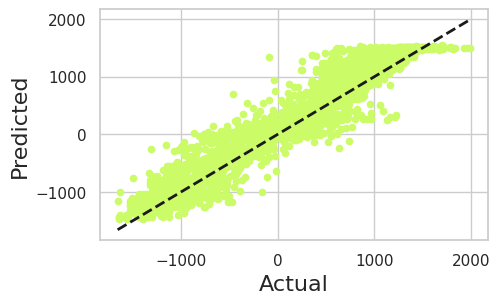

In [ ]:
history = best_model.fit(X_train_reshaped, y_train_array, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
y_pred_3d = best_model.predict(X_test_reshaped)
y_pred = y_pred_3d.reshape(-1, y_pred_3d.shape[-1])
evaluate(best_model, y_test, y_pred)  # Your custom evaluate function


In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Predictions on Xtest

MSE: 41200.07
RMSE: 202.98
MAE: 134.92
nRMSE: 5.57 %
CV-RMSE: 57.17 %
R2 score: 0.919


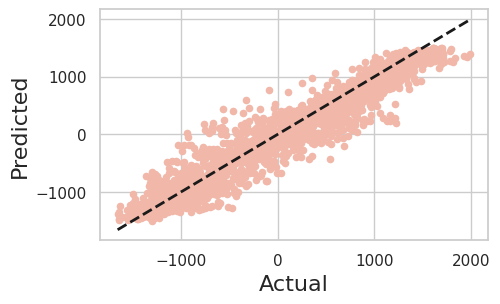

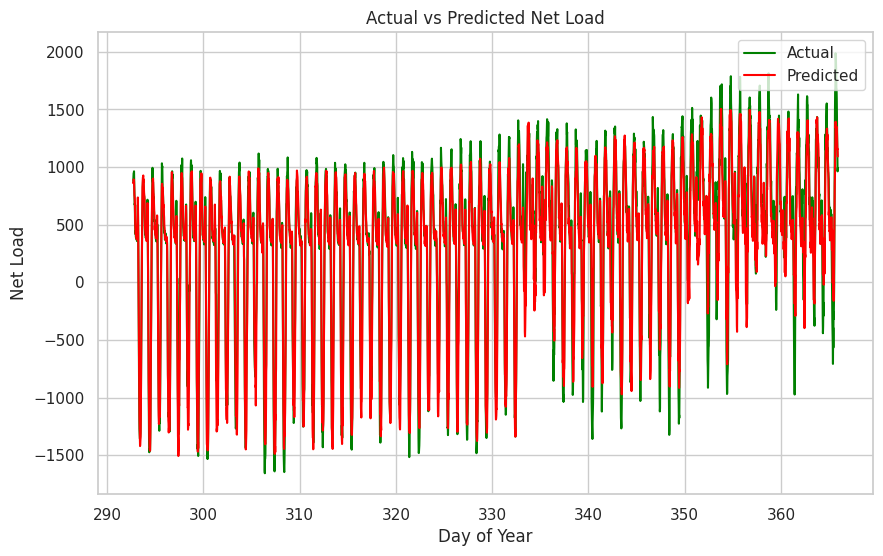

In [ ]:
### DO some predictions!!

#Choose model to show predictions:
y_pred = model4.predict(X_test)
evaluate(model4)

# Plot the training and test output
plt.figure(figsize=(10, 6))
#plt.plot( y_train.index/48, y_train, label='Training set', color='blue')
#plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test Output', color='orange')


# Plot actual vs predicted values
plt.plot( y_test.index/48 , y_test, label='Actual', color='green')
plt.plot( y_test.index/48 , y_pred, label='Predicted', color='red')
#plt.scatter( y_test.index, y_test, label='Actual', s=5)
#plt.scatter( y_test.index, y_pred, label='Predicted', s=5)
plt.xlabel('Day of Year')
plt.ylabel('Net Load')
plt.title('Actual vs Predicted Net Load')
plt.legend()
plt.legend(loc='upper right')

plt.show()

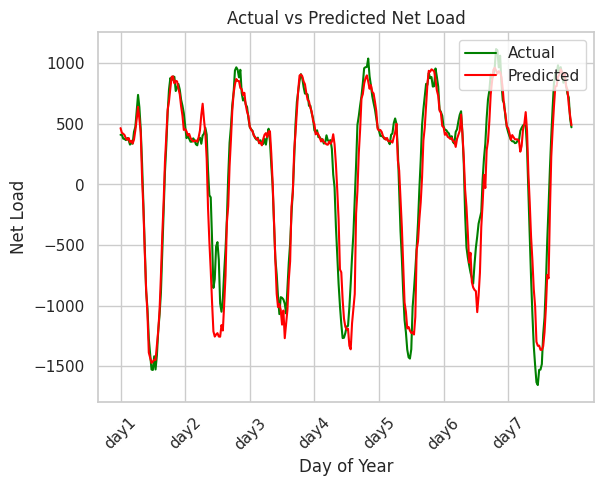

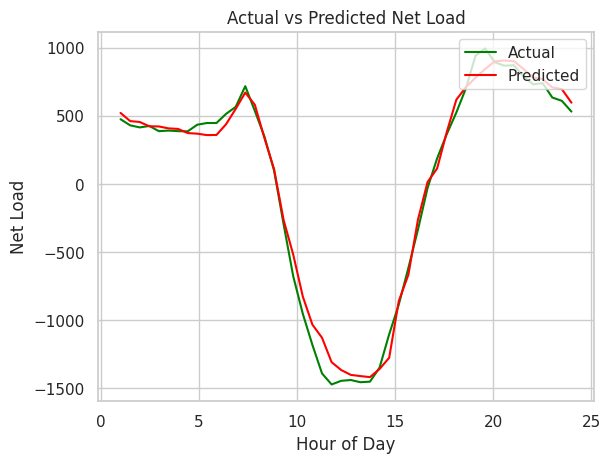

In [ ]:
#Plot a week (real and predicted)

#week_nr = 43
week_nr = 47
indices = y_test.index

week_data = yearday_df['Timestamp'].iloc[48*7*week_nr:48*7*(week_nr+1)]
#week_data = ["day1","day2","day3","day4","day5","day6","day7"]

#plt.plot( indices[48*7*week_nr:48*7*(week_nr+1)]/48 , y_test[48*7*week_nr:48*7*(week_nr+1)], label='Test set', color='green')
plt.plot( week_data, y_test[48*7+10:48*7*(1+1)+10], label='Actual', color='green')
#plt.plot( indices[48*7*1:48*7*(1+1)]/48 , y_pred[48*7*1:48*7*(1+1)], label='Predicted', color='red')
plt.plot( week_data , y_pred[48*7+10:48*7*(1+1)+10], label='Predicted', color='red')
plt.xlabel('Day of Year')
plt.ylabel('Net Load')
plt.title('Actual vs Predicted Net Load')
plt.legend(loc='upper right')
plt.xticks(rotation=-45)

# Customizing the x-axis ticks to show "day1", "day2", ..., "day7"
# we want to label every 48 hours (daily ticks)
num_days = 7
labels = [f'day{i+1}' for i in range(num_days)]
# Set the ticks at the start of each day
tick_locs = week_data[::48][:num_days]  # Adjust to match the data frequency
plt.xticks(ticks=tick_locs, labels=labels, rotation=45)

plt.show()

#Plot a daily profile (real and predicted)
plt.plot( np.linspace(1, 24, 48) , y_test[48*1+10:48*(1+1)+10], label='Actual', color='green')
plt.plot( np.linspace(1, 24, 48) , y_pred[48*1+10:48*(1+1)+10], label='Predicted', color='red')
plt.xlabel('Hour of Day')
plt.ylabel('Net Load')
plt.title('Actual vs Predicted Net Load')
plt.legend(loc='upper right')
plt.show()

In [ ]:
week_data

15792   2016-11-25 02:00:00
15793   2016-11-25 02:30:00
15794   2016-11-25 03:00:00
15795   2016-11-25 03:30:00
15796   2016-11-25 04:00:00
                ...        
16123   2016-12-01 23:30:00
16124   2016-12-02 00:00:00
16125   2016-12-02 00:30:00
16126   2016-12-02 01:00:00
16127   2016-12-02 01:30:00
Name: Timestamp, Length: 336, dtype: datetime64[ns]

<class 'pandas.core.series.Series'>
RangeIndex: 336 entries, 336 to 671
Series name: Timestamp
Non-Null Count  Dtype         
--------------  -----         
336 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.8 KB


(array([16808., 16809., 16810., 16811., 16812., 16813., 16814., 16815.]),
 [Text(16808.0, 0, '2016-01-08'),
  Text(16809.0, 0, '2016-01-09'),
  Text(16810.0, 0, '2016-01-10'),
  Text(16811.0, 0, '2016-01-11'),
  Text(16812.0, 0, '2016-01-12'),
  Text(16813.0, 0, '2016-01-13'),
  Text(16814.0, 0, '2016-01-14'),
  Text(16815.0, 0, '2016-01-15')])

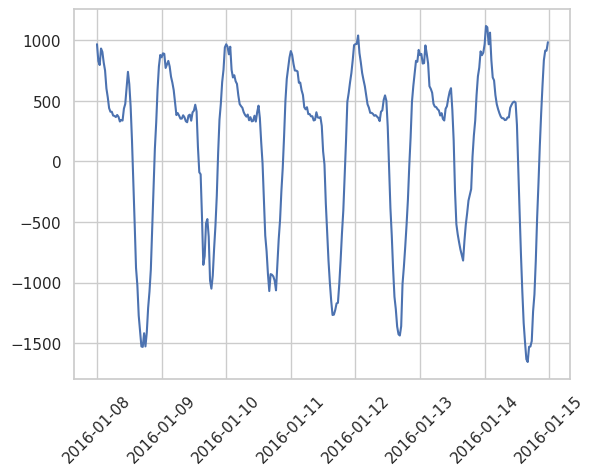

In [ ]:
#yearday_df.info()
week_43_data.info()
plt.plot(week_43_data, y_test[48*7*week_nr:48*7*(week_nr+1)])
plt.xticks(rotation=45)

# Predicitons on Validation set with Forecasted data (day-ahead)

In [110]:
#### Load data set
# Should have the same columns as X_train
# might need to adjust the csv file
X_val = pd.read_csv('forecasts_20240830_0906.csv')
X_val.info()
X_val.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            337 non-null    float64
 1   dhi                 337 non-null    int64  
 2   ghi                 337 non-null    int64  
 3   relative_humidity   337 non-null    float64
 4   wind_direction_10m  337 non-null    float64
 5   wind_speed_10m      337 non-null    float64
 6   day                 337 non-null    int64  
 7   day_of_week         337 non-null    int64  
 8   month               337 non-null    int64  
 9   hour_of_day         337 non-null    int64  
 10  NL_lag1             337 non-null    float64
 11  NL_lag2             337 non-null    float64
 12  NL_lag7             337 non-null    float64
 13  NL_rolling_avg_1    337 non-null    float64
 14  NL_rolling_avg_7    337 non-null    float64
dtypes: float64(9), int64(6)
memory usage: 39.6 KB


air_temp  dhi  ghi  relative_humidity  wind_direction_10m  wind_speed_10m  \
0     25.40   93  647             75.100               214.5            4.80   
1     26.05   99  727             71.015               198.8            4.15   
2     26.70  107  794             66.930               183.1            3.50   
3     27.30  112  848             63.305               167.4            2.85   
4     27.90  116  888             59.680               151.7            2.20   

   day  day_of_week  month  hour_of_day      NL_lag1      NL_lag2     NL_lag7  \
0   31            2      8            9  -150.966119    18.845522  -45.722537   
1   31            2      8            9  -435.702121  -321.111912 -282.117463   
2   31            2      8           10  -704.054478  -558.926323 -562.155672   
3   31            2      8           10  -968.011618  -824.534265 -763.103134   
4   31            2      8           11 -1118.145000 -1061.600000 -835.732794   

   NL_rolling_avg_1  NL_rolling_avg_7  
0        374.646041        506.130969  
1        375.180144        505.750172  
2        376.576895        505.527390  
3        378.840115        505.240861  
4        379.393880        504.479458

In [111]:
### Scale the Xval
scaler.fit(X_val)
# Transform the training data
X_val_scaled = scaler.transform(X_val)
# Convert the scaled arrays back to DataFrame for easier handling
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_val_scaled.info()
X_val_scaled.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            337 non-null    float64
 1   dhi                 337 non-null    float64
 2   ghi                 337 non-null    float64
 3   relative_humidity   337 non-null    float64
 4   wind_direction_10m  337 non-null    float64
 5   wind_speed_10m      337 non-null    float64
 6   day                 337 non-null    float64
 7   day_of_week         337 non-null    float64
 8   month               337 non-null    float64
 9   hour_of_day         337 non-null    float64
 10  NL_lag1             337 non-null    float64
 11  NL_lag2             337 non-null    float64
 12  NL_lag7             337 non-null    float64
 13  NL_rolling_avg_1    337 non-null    float64
 14  NL_rolling_avg_7    337 non-null    float64
dtypes: float64(15)
memory usage: 39.6 KB


air_temp       dhi       ghi  relative_humidity  wind_direction_10m  \
0  -0.483207  0.165454  1.194536           0.652499           -0.434945   
1  -0.289242  0.232849  1.443439           0.386707           -0.648016   
2  -0.095278  0.322709  1.651896           0.120915           -0.861086   
3   0.083767  0.378872  1.819907          -0.114946           -1.074157   
4   0.262811  0.423802  1.944358          -0.350808           -1.287228   
5   0.441855  0.468732  2.015918          -0.559993           -1.590548   
6   0.620899  0.524894  2.034586          -0.769178           -1.893869   
7   0.949147  1.861562  1.711011          -0.955265           -2.197868   
8   1.277395  1.120217  1.804350          -1.141351           -2.501867   
9   1.725006  1.210077  1.655008          -1.516453           -2.012618   
10  2.172617  1.266240  1.458996          -1.891554           -1.523370   
11  2.336741  1.288705  1.228760          -2.048362           -2.075725   
12  2.500865  1.232542  0.973633          -2.205169           -2.628081   
13  2.650068  1.165147  0.684283          -2.307647           -0.613409   
14  2.799272  1.041590  0.370041          -2.410125            1.401264   
15  2.754511  0.794475  0.065134          -2.364579            1.112872   
16  2.709750  0.446267 -0.221105          -2.319033            0.824480   
17  2.500865  0.019432 -0.488677          -2.086750            0.715909   
18  2.291980 -0.474798 -0.700245          -1.854467            0.607338   
19  1.963732 -0.856703 -0.812252          -1.401938            0.617516   

    wind_speed_10m       day  day_of_week     month  hour_of_day   NL_lag1  \
0        -0.690107  3.118859    -0.499073 -3.198958    -0.360552 -0.699270   
1        -0.797456  3.118859    -0.499073 -3.198958    -0.360552 -1.037189   
2        -0.904804  3.118859    -0.499073 -3.198958    -0.215902 -1.355665   
3        -1.012153  3.118859    -0.499073 -3.198958    -0.215902 -1.668924   
4        -1.119501  3.118859    -0.499073 -3.198958    -0.071252 -1.847099   
5        -0.946092  3.118859    -0.499073 -3.198958    -0.071252 -1.933514   
6        -0.772683  3.118859    -0.499073 -3.198958     0.073398 -1.946186   
7        -0.591017  3.118859    -0.499073 -3.198958     0.073398 -2.062024   
8        -0.409350  3.118859    -0.499073 -3.198958     0.218048 -1.965479   
9        -0.409350  3.118859    -0.499073 -3.198958     0.218048 -1.905336   
10       -0.409350  3.118859    -0.499073 -3.198958     0.362698 -1.672522   
11       -0.467153  3.118859    -0.499073 -3.198958     0.362698 -1.469650   
12       -0.524956  3.118859    -0.499073 -3.198958     0.507348 -1.293327   
13       -0.557986  3.118859    -0.499073 -3.198958     0.507348 -1.014828   
14       -0.591017  3.118859    -0.499073 -3.198958     0.651997 -0.963747   
15        0.565043  3.118859    -0.499073 -3.198958     0.651997 -0.765793   
16        1.721103  3.118859    -0.499073 -3.198958     0.796647 -0.519108   
17        1.547694  3.118859    -0.499073 -3.198958     0.796647 -0.320785   
18        1.374285  3.118859    -0.499073 -3.198958     0.941297  0.165556   
19        1.580724  3.118859    -0.499073 -3.198958     0.941297  0.368987   

     NL_lag2   NL_lag7  NL_rolling_avg_1  NL_rolling_avg_7  
0  -0.509540 -0.632297         -0.823266          2.583430  
1  -0.912697 -0.903958         -0.816416          2.560989  
2  -1.194721 -1.225772         -0.798501          2.547860  
3  -1.509707 -1.456697         -0.769473          2.530974  
4  -1.790843 -1.540162         -0.762370          2.486103  
5  -1.749221 -1.712986         -0.788476          2.433041  
6  -1.841733 -1.768228         -0.797948          2.397454  
7  -1.934049 -1.857904         -0.781937          2.375163  
8  -1.807043 -1.803623         -0.765508          2.359129  
9  -1.621886 -1.693828         -0.735258          2.344298  
10 -1.423331 -1.314823         -0.712251          2.301274  
11 -1.245201 -1.085389         -0.710467          2.23928

In [112]:
# Define the y_val
#y_val = pd.read_csv('actual_20240830_0906.csv')
day_of_forecast = 243 # day of the year
day_index = 48*day_of_forecast + 16;

y_val = output['NetLoad'].iloc[day_index:day_index+len(X_val)]

y_val.info()
y_val.head()

<class 'pandas.core.series.Series'>
Index: 337 entries, 11680 to 12016
Series name: NetLoad
Non-Null Count  Dtype  
--------------  -----  
337 non-null    float64
dtypes: float64(1)
memory usage: 5.3 KB


11680    -637.010448
11681    -859.377059
11682   -1091.564265
11683   -1288.654853
11684   -1237.088209
Name: NetLoad, dtype: float64

MSE: 150584.15
RMSE: 388.05
MAE: 319.57
MAPE: 100.44 %
CV-RMSE: 90.24 %
nRMSE: 13.72 %
R2 score: 0.786


0.1371766770362703

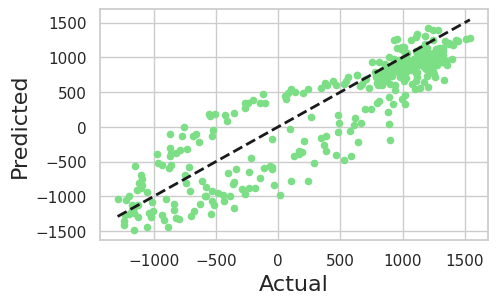

In [115]:
### Do the predictions
y_pred = model4.predict(X_val_scaled)

evaluate(model4, y_val, y_pred)

# ARIMA / SARIMAX methods (unfinished)


* Seasonal AutoRegressive
* Integrated Moving Average.
* time series data to predict future trends.

In [ ]:
!pip install statsmodels

In [ ]:
####### Arima Forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import numpy as np

## Get the correct data
consumption_data = pd.DataFrame(yearday_df['Consumption'])
#consumption_data = combined_df['Consumption']
#consumption_data = pd.DataFrame(avg365_df['Consumption'])
#consumption_data = avg365_df

#consumption_data = consumption_data.rename(columns={consumption_data.columns[0]: 'Timestamp'})
#consumption_data['Timestamp'] = pd.to_datetime(consumption_data['Timestamp'])
#consumption_data['Timestamp'] = consumption_data['Timestamp'].apply(lambda x: x.replace(year=2016))

consumption_data.info()
consumption_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  17564 non-null  float64
dtypes: float64(1)
memory usage: 137.3 KB


Consumption
0  1034.182794
1   892.905882
2   995.311765
3   855.753088
4   828.964706

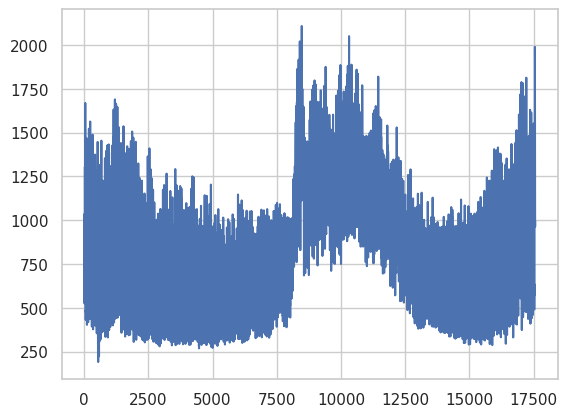

In [ ]:
plt.plot(consumption_data)

Seasonal Decomposition

In [ ]:
yearday_df.head()

Timestamp    NM_meter       Import  Export    PV_meter  \
0 2016-01-01 00:00:00  614.941176  1034.182794     0.0  586.632353   
1 2016-01-01 00:30:00  614.941176   892.905882     0.0  586.632353   
2 2016-01-01 01:00:00  614.941176   995.311765     0.0  586.632353   
3 2016-01-01 01:30:00  614.941176   855.753088     0.0  586.632353   
4 2016-01-01 02:00:00  614.941176   828.964706     0.0  586.632353   

   Production  Consumption      NetLoad  day  day_of_week  month    year  \
0         0.0  1034.182794  1034.182794  1.0          4.0    1.0  2016.0   
1         0.0   892.905882   892.905882  1.0          4.0    1.0  2016.0   
2         0.0   995.311765   995.311765  1.0          4.0    1.0  2016.0   
3         0.0   855.753088   855.753088  1.0          4.0    1.0  2016.0   
4         0.0   828.964706   828.964706  1.0          4.0    1.0  2016.0   

   hour_of_day  quarter  
0          0.0      1.0  
1          0.0      1.0  
2          1.0      1.0  
3          1.0      1.0  
4          2.0      1.0

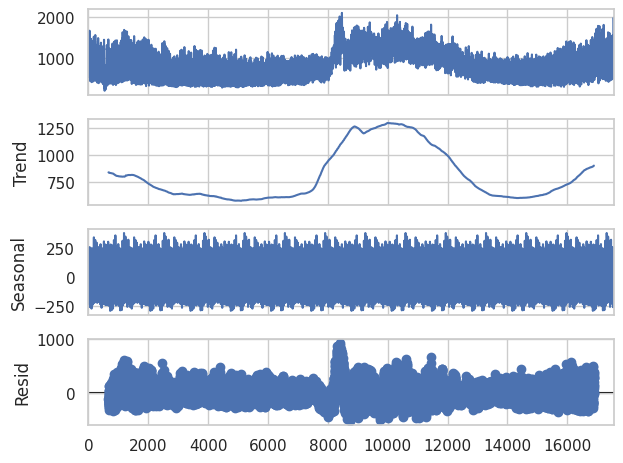

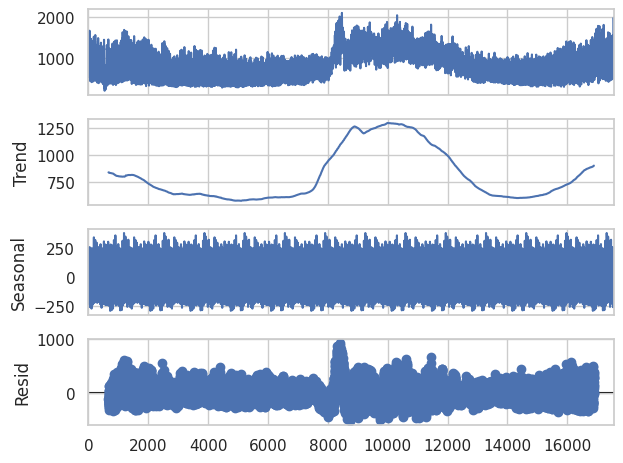

In [ ]:
###seasonal decomposition of time series (STL) method
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
#result = sm.tsa.seasonal_decompose(combined_df['Consumption'], model='additive', period=24*365)
# Adjust period according to your data's seasonality
# for daily seasonality:period = 24 (hrs)
# for weekly seasonality, period = 7*24
# for monthlyseasonality, period = 7*24*4
#period = int(len(consumption_data)/12)
result = seasonal_decompose(consumption_data, model='additive', period=48*7*4)

# Plot the decomposed components
result.plot()


Looks like Random Walk. Non-stationary




In [ ]:
def test_stationarity(timeseries, window):
  import matplotlib.pyplot as plt

  timeseries.dropna(inplace=True)

  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries, label='original')
  mean = plt.plot(rolmean, label='rolling mean')
  std = plt.plot(rolstd, label='rolling std')

  plt.legend(loc = 'best')
  plt.title('timeseries with roll avg')

  from statsmodels.tsa.stattools import adfuller
  adf_test = adfuller(timeseries)
  adf_output = pd.Series(adf_test[0:4], index = ['test statistic', 'p-value', '#used Lags', 'NOBS'])

  print(adf_output)


test statistic       -2.103994
p-value               0.242912
#used Lags           44.000000
NOBS              17519.000000
dtype: float64


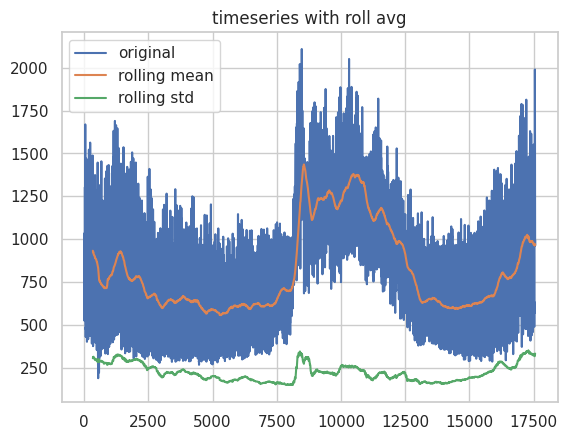

In [ ]:
### Determine window
window = 336  # window = 7*24*2

## Test stationarity
test_stationarity(consumption_data, window )

p >0.05 so test fails the hypothesis that data is stationary

Transform to stationary:
 * Differentiate or
 * Take the Log of data
 * take the ma

test statistic       -2.299890
p-value               0.172003
#used Lags           44.000000
NOBS              17519.000000
dtype: float64


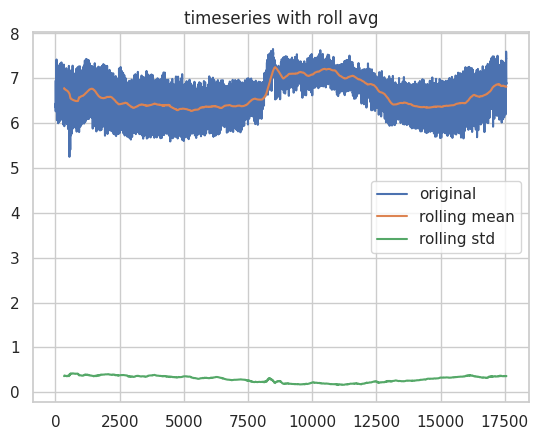

In [ ]:
###  Take the Log of data
cons_data_log = np.log(consumption_data)
test_stationarity(cons_data_log, window)


data is still seasonal. Not stationary

test statistic   -7.472090e+00
p-value           5.023687e-11
#used Lags        4.400000e+01
NOBS              1.718400e+04
dtype: float64


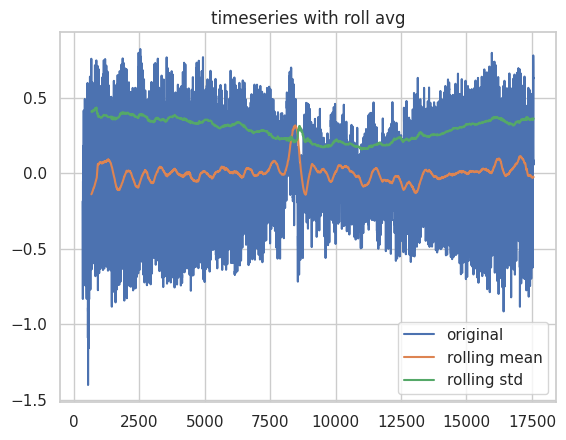

In [ ]:
# Remove the MA
ma = cons_data_log.rolling(window=window).mean()
cons_data_log_ma_removed = cons_data_log - ma
test_stationarity(cons_data_log_ma_removed, window)


We assume the model is stationary. Even though from the plot we see it's not

test statistic      -74.16332
p-value               0.00000
#used Lags           44.00000
NOBS              17183.00000
dtype: float64


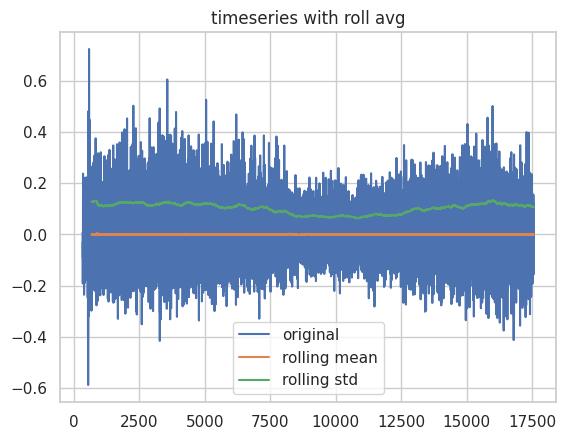

In [ ]:
## Take the derivative of the data. Should be stationary (noise around zero)
cons_data_log_ma_removed_diff = cons_data_log_ma_removed.diff().dropna()

## second derivative
#cons_data_log_ma_removed_diff2 = cons_data_log_ma_removed_diff().dropna()
#consn_data_diff = consumption_data.diff()

test_stationarity(cons_data_log_ma_removed_diff,window)


BEfor we do ARIMA we need to find the p, q values
Plot Autocorrelation (ACF) and Partial ACF function

In [ ]:
####
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Autocorrelation Function (ACF) plot
#plt.figure(figsize=(12, 6))
plot_acf(cons_data_log_ma_removed, lags=50, ax=plt.gca())
#plot_acf(cons_data_log_ma_removed_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Partial Autocorrelation Function (PACF) plot
#plt.figure(figsize=(12, 6))
plot_pacf(cons_data_log_ma_removed, lags=50, ax=plt.gca())
#plot_pacf(cons_data_log_ma_removed_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


NameError: name 'cons_data_log_ma_removed' is not defined

q converges to 8
p converges to 3

So the d in ARIMA is 1

Determine the **p** and **q**:

if the PACF plot has significant spike at lag p, but not beyond && the ACF plot decays more gradually.
This suggests an ARIMA(p,d,0)

if the ACF plot has significant spike at lag q, but not beyond, && the PACF plot decays more gradually,
This suggests an ARIMA(0,d,q)

Now let's do the ARIMA

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split

#train_size = int(len(consumption_data) * 0.8)
#train, test = cons_data_log_ma_removed.iloc[:train_size], consumption_data.iloc[train_size:]
train, test = train_test_split(cons_data_log_ma_removed, test_size = 0.2, shuffle=False)

# Fit an ARIMA model
# The parameters (p, d, q) need to be chosen based on the nature of your time series data
# p is the number of lag observations included in the model (lag order)
# d is the number of times that the raw observations are differenced (degree of differencing)
# q is the size of the moving average window (order of moving average)

model5 = ARIMA(train, order=(9,1,2))  # Example order, tune these parameters
#model5 = SARIMAX(train, order=(2,1,1), seasonal_order=(2, 1, 1, 8736))
model_fit = model5.fit()

# Summary of the model
print(model_fit.summary())


In [ ]:
import matplotlib.pyplot as plt
# Check residuals

#figure(12,6)
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'residuals', ax=ax[0])
residuals.plot(title = 'density', kind = 'kde',ax=ax[1])

plt.show

In [ ]:
ma[284:354]
#predictions

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import math
# Make predictions / forecast
start_index = len(train)
end_index = start_index + len(test) - 1
predictions = model_fit.predict(start=start_index, end=end_index, typ='levels')

## convert back to normal. The data was log. Need to exp them
#preds_ma = predictions + predictions.rolling(window=12).mean()
#test_ma = test + test.rolling(window=12).mean()

exp_preds = np.exp(predictions)
exp_test = np.exp(test)

# Calculate MSE
mse = mean_squared_error(test, predictions)
print('Mean Squared Error:', mse)

# Plot actual vs predicted values
#plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, exp_test.values, label='Actual')
#plt.plot(test.index, predictions, label='Predicted')
plt.plot(test.index, exp_preds, label='Predicted')
plt.xlabel('sample')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Consumption')
plt.legend()
plt.show()


In [ ]:
# Make forecast
num_steps = int(0.2*len(consumption_data))
forecast = model_fit.forecast(steps=num_steps)

## convert it back to


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(consumption_data.index, consumption_data, label='Historical Data')

#plt.plot(np.arange(len(consumption_data), len(consumption_data) + num_steps), forecast, label='Forecast', color='red')
plt.plot(forecast.index , forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

In [ ]:
!pip install pmdarima


In [ ]:
import pmdarima as pm
auto_arima = pm.auto_arima(train , stepwise=False, seasonal=True, m=12)
auto_arima

In [ ]:
auto_arima.summary()

In [ ]:
#### Try to find the best arima models
import itertools
import pandas as pd
import statsmodels.api as sm

# Define the range of p, d, and q values
p_range = range(0, 10)  # Example range, adjust as needed
d_range = range(0, 10)  # Example range, adjust as needed
q_range = range(0, 10)  # Example range, adjust as needed

# Generate all possible combinations of p, d, and q values
pdq = list(itertools.product(p_range, d_range, q_range))

# Initialize variables to store best parameters and lowest AIC
best_params = None
best_aic = float('inf')

# Iterate over all combinations and fit ARIMA models
for params in pdq:
    try:
        model = sm.tsa.ARIMA(train, order=params)
        results = model.fit()
        # Calculate AIC
        aic = results.aic
        # Update best parameters if current model has lower AIC
        if aic < best_aic:
            best_params = params
            best_aic = aic
    except:
        continue

# Fit ARIMA model with best parameters on the entire dataset
best_model = sm.tsa.ARIMA(train, order=best_params)
best_results = best_model.fit()

# Print best parameters and AIC
print('Best Parameters:', best_params)
print('Best AIC:', best_aic)

# Make predictions with the best model
predictions = best_results.predict(start=start_index, end=end_index, typ='levels')


# FB Prophet model (unfinished)


In [ ]:
!pip install prophet


In [ ]:
data['ds'] = pd.to_datetime(data['date_column'])  # Adjust 'date_column' to your actual date column name
data['y'] = data['consumption_column']  # Adjust 'consumption_column' to your actual data column name

# Select only the needed columns
data = data[['ds', 'y']]

In [ ]:
from prophet import Prophet
# Initialize the Prophet model
m = Prophet()

# Fit the model
m.fit(data)

In [ ]:
# Create a dataframe to hold predictions
future = m.make_future_dataframe(periods=365)  # for example, forecasting for the next year

# Make predictions
forecast = m.predict(future)

# Forecast includes several components: trend, yearly seasonality, and weekly seasonality by default
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

# Plot the forecast
plot_plotly(m, forecast)

# To see the trend, yearly and weekly seasonality
plot_components_plotly(m, forecast)


In [ ]:
# Adding custom seasonality
m = Prophet()
m.add_seasonality(name='biannual', period=365.25/2, fourier_order=5)

# Add holidays
holidays = pd.DataFrame({
  'holiday': 'holiday_name',
  'ds': pd.to_datetime(['2023-12-25', '2024-01-01']),
  'lower_window': 0,
  'upper_window': 1,
})
m = Prophet(holidays=holidays)

# Fit and predict as before
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# Plotting
plot_plotly(m, forecast)
